# Import Libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive')
import numpy as np
import pandas as pd

import os
import time
import gc

from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import mean_squared_error, accuracy_score, roc_auc_score, log_loss, f1_score, precision_score, recall_score
from sklearn.ensemble import ExtraTreesClassifier

from lightgbm import LGBMClassifier

import random

import warnings
warnings.filterwarnings("ignore")

from tqdm import tqdm
from keras.preprocessing import text, sequence
import torch
from torch import nn
from torch.utils import data
from torch.nn import functional as F
import matplotlib.pyplot as plt
import pickle
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

Mounted at /content/drive


# Data Augmentation

In [2]:
test2 = pd.read_csv('/content/drive/MyDrive/data/appended_new_opcodes.csv')
test = pd.read_csv('/content/drive/MyDrive/data/appended_result_embed.csv')
test.head()

,ID,Family,0,1,2,3,4,5,6,7,...,90,91,92,93,94,95,96,97,98,99
0,01kcPWA9K2BOxQeS5Rju,1,-0.426271,1.495527,0.442969,-1.784287,0.687246,-0.163921,-0.821085,-0.767919,...,-0.816768,-1.232931,0.312494,0.956752,0.134952,0.596190,-0.748863,-0.692929,1.376552,-0.300369
1,04EjIdbPV5e1XroFOpiN,1,-0.429474,1.381561,0.241621,-0.654752,0.227177,-0.599185,-0.663230,-0.332880,...,-0.419219,-0.413807,-0.152669,0.227969,0.036689,1.294578,-0.139708,-0.803917,1.071521,-0.173929
2,05EeG39MTRrI6VY21DPd,1,-0.386531,1.551624,0.240367,-0.513145,0.496933,-0.666564,-0.377270,-0.464443,...,-0.594439,-0.584387,-0.087269,0.306046,0.010809,1.528025,-0.402952,-0.582781,1.199226,-0.128288
3,05rJTUWYAKNegBk2wE8X,1,-0.355359,1.305468,0.119359,-0.908725,0.154450,-0.639722,-0.896534,-0.308548,...,-0.354546,-0.347760,-0.217605,0.317562,0.046546,1.289890,-0.135289,-0.718038,1.174416,-0.230006
4,0AnoOZDNbPXIr2MRBSCJ,1,-0.193080,1.316853,-0.107708,-0.632932,0.209633,-0.560659,-0.372401,-0.302188,...,-0.367623,-0.139803,-0.225833,-0.011875,0.134646,1.751419,-0.285946,-0.762208,1.015983,0.295280


In [3]:
test2= pd.DataFrame(test['ID']).merge(test2, on='ID').reset_index(drop = True)
test2.head()

,ID,Opcodes,Family
0,01kcPWA9K2BOxQeS5Rju,push push mov push mov sub mov push push lea m...,1
1,04EjIdbPV5e1XroFOpiN,push push mov push mov mov mov lea push retn m...,1
2,05EeG39MTRrI6VY21DPd,push mov mov test mov jz push call mov test jz...,1
3,05rJTUWYAKNegBk2wE8X,cmp jnz test jnz retn mov push mov mov push mo...,1
4,0AnoOZDNbPXIr2MRBSCJ,push mov sub mov and and push push mov cmp mov...,1


In [4]:
vectorizer = TfidfVectorizer()
tf_encs = vectorizer.fit_transform(test2['Opcodes'])
tf_encs = tf_encs.toarray()
Xx = pd.DataFrame(tf_encs)

In [5]:
test= test.reset_index(drop = True)
test['Family'] = test['Family'] - 1
test.head()

,ID,Family,0,1,2,3,4,5,6,7,...,90,91,92,93,94,95,96,97,98,99
0,01kcPWA9K2BOxQeS5Rju,0,-0.426271,1.495527,0.442969,-1.784287,0.687246,-0.163921,-0.821085,-0.767919,...,-0.816768,-1.232931,0.312494,0.956752,0.134952,0.596190,-0.748863,-0.692929,1.376552,-0.300369
1,04EjIdbPV5e1XroFOpiN,0,-0.429474,1.381561,0.241621,-0.654752,0.227177,-0.599185,-0.663230,-0.332880,...,-0.419219,-0.413807,-0.152669,0.227969,0.036689,1.294578,-0.139708,-0.803917,1.071521,-0.173929
2,05EeG39MTRrI6VY21DPd,0,-0.386531,1.551624,0.240367,-0.513145,0.496933,-0.666564,-0.377270,-0.464443,...,-0.594439,-0.584387,-0.087269,0.306046,0.010809,1.528025,-0.402952,-0.582781,1.199226,-0.128288
3,05rJTUWYAKNegBk2wE8X,0,-0.355359,1.305468,0.119359,-0.908725,0.154450,-0.639722,-0.896534,-0.308548,...,-0.354546,-0.347760,-0.217605,0.317562,0.046546,1.289890,-0.135289,-0.718038,1.174416,-0.230006
4,0AnoOZDNbPXIr2MRBSCJ,0,-0.193080,1.316853,-0.107708,-0.632932,0.209633,-0.560659,-0.372401,-0.302188,...,-0.367623,-0.139803,-0.225833,-0.011875,0.134646,1.751419,-0.285946,-0.762208,1.015983,0.295280


# Utility functions

In [10]:
def train_model(data_loader, model, optimizer, device):
  """
  This function does training for one epoch
  :param data_loader: this is the pytorch dataloader
  :param model: pytorch model
  :param optimizer: optimizer, for e.g. adam, sgd, etc
  :param device: cuda/cpu
  """
  # put the model in train mode
  model.train()
  # scheduler = get_scheduler(optimizer, 'CosineAnnealingWarmRestarts')
  # go over every batch of data in data loader
  for data in tqdm(data_loader):
    # remember, we have image and targets
    # in our dataset class
    inputs = data["X"]
    targets = data["targets"]

    # move inputs/targets to cuda/cpu device
    inputs = inputs.to(device, dtype=torch.float)
    targets = targets.to(device, dtype=torch.float)

    # zero grad the optimizer
    optimizer.zero_grad()
    #do the forward step of model
    outputs = model(inputs)
    # calculate loss

    loss = nn.CrossEntropyLoss()(outputs,targets.long())
    # backward step the loss
    loss.backward()
    # step optimizer
    optimizer.step()
    # if you have a scheduler, you either need to
    # step it here or you have to step it after
    # the epoch. here, we are not using any learning
    # rate scheduler
  # scheduler.step()

def evaluate_model(data_loader, model, device):
  """
  This function does evaluation for one epoch
  :param data_loader: this is the pytorch dataloader
  :param model: pytorch model
  :param device: cuda/cpu
  """
  # put model in evaluation mode
  model.eval()

  # init lists to store targets and outputs
  final_targets = []
  final_outputs = []

  # we use no_grad context
  with torch.no_grad():
    for data in tqdm(data_loader):
      inputs = data["X"]
      targets = data["targets"]
      inputs = inputs.to(device, dtype=torch.float)
      targets = targets.to(device, dtype=torch.float)

      # do the forward step to generate prediction
      output = model(inputs)

      # convert targets and outputs to lists
      targets = targets.detach().cpu().numpy().tolist()
      output = output.detach().cpu().numpy().tolist()

      # extend the original list
      final_targets.extend(targets)
      final_outputs.extend(output)

  # return final output and final targets
  return final_outputs, final_targets

import os
def save_checkpoint(model, optimizer, path):
    if not os.path.exists(os.path.dirname(path)):
        print("Creating directories on path: `{}`".format(path))
        os.makedirs(os.path.dirname(path))

    torch.save({
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
    }, path)


def load_checkpoint(model, path):
    checkpoint = torch.load(path)

    model.load_state_dict(checkpoint["model_state_dict"])

    optimizer = torch.optim.Adam(model.parameters())
    optimizer.load_state_dict(checkpoint["optimizer_state_dict"])

    return model, optimizer


def save_model(model, path):
  if not os.path.exists(os.path.dirname(path)):
      print("Creating directories on path: `{}`".format(path))
      os.makedirs(os.path.dirname(path))

  torch.save({
      "model_state_dict": model.state_dict(),
  }, path)


def load_model(model, path):
  restore_dict = torch.load(path)

  model.load_state_dict(restore_dict["model_state_dict"])
  model.eval()

  return model

from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau

def get_scheduler(optimizer, scheduler):
    if scheduler=='ReduceLROnPlateau':
        scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=4, verbose=True, eps=1e-6)
    elif scheduler=='CosineAnnealingLR':
        scheduler = CosineAnnealingLR(optimizer, T_max=10, eta_min=1e-6, last_epoch=-1)
    elif scheduler=='CosineAnnealingWarmRestarts':
        scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=1, eta_min=1e-6, last_epoch=-1)
    return scheduler

In [11]:
LSTM_UNITS = 128
GRU_UNITS = 128
DENSE_HIDDEN_UNITS = 4 * LSTM_UNITS
MAX_LEN = 100

In [12]:
class NeuralNet(nn.Module):
    def __init__(self, input_shape, num_aux_targets):
        super(NeuralNet, self).__init__()
        self.lstm = nn.LSTM(input_shape, LSTM_UNITS, bidirectional=True, batch_first=True)
        self.gru = nn.GRU(input_shape, GRU_UNITS, bidirectional=True, batch_first=True)

        self.linear1 = nn.Linear(LSTM_UNITS*2, DENSE_HIDDEN_UNITS)
        self.linear2 = nn.Linear(GRU_UNITS*2, DENSE_HIDDEN_UNITS)

        self.attention = nn.Sequential(
            nn.Linear(DENSE_HIDDEN_UNITS, 256),
            nn.Tanh(),
            nn.Linear(256, 1),
            nn.Softmax(dim=1)
        )


        self.linear_out = nn.Linear(DENSE_HIDDEN_UNITS, num_aux_targets)
        # self.linear_aux_out = nn.Linear(DENSE_HIDDEN_UNITS, num_aux_targets)

    def forward(self, x):
        x = x.view((-1,1,100))
        h_lstm, _ = self.lstm(x)
        h_gru, _ = self.gru(x)

        h_lstm = h_lstm.squeeze()
        h_gru = h_gru.squeeze()

        # global average pooling
        # avg_pool = torch.mean(h_lstm2, 1)
        # global max pooling
        # max_pool, _ = torch.max(h_lstm2, 1)

        # h_conc = torch.cat((max_pool, avg_pool), 1)
        h_conc_linear1  = F.relu(self.linear1(h_lstm))
        h_conc_linear2  = F.relu(self.linear2(h_gru))

        hidden = (h_conc_linear1 + h_conc_linear2)/2

        weights = self.attention(hidden)

        context_vector = weights * hidden

        # print(context_vector.shape)
        # print(weights.shape)
        # print(hidden.shape)

        results = self.linear_out(context_vector)

        return nn.Softmax(dim=1)(results)

In [13]:
class Dataset:
  def __init__(self, X, targets):
    self.X = X
    self.target = targets

  def __len__(self):
    return len(self.X)

  def __getitem__(self, item):
    X = self.X[item, :]
    target = self.target[item]
    return {
      "X": torch.tensor(X, dtype=torch.float),
      "targets": torch.tensor(target, dtype=torch.float)
    }

In [14]:
epochs = 50
device = 'cpu'

In [15]:
def inference(data_loader, model, device):
  model.eval()

  final_outputs = []

  with torch.no_grad():
    for data in tqdm(data_loader):
      inputs = data["X"]

      inputs = inputs.to(device, dtype=torch.float)

      output = model(inputs)

      # convert targets and outputs to lists
      output = output.detach().cpu().numpy().tolist()

      # extend the original list
      final_outputs.extend(output)

  # return final output and final targets
  return final_outputs

# Append attack

In [6]:
# 1:08 - 1:25
class TestDataset:
  def __init__(self, X):
    self.X = X

  def __len__(self):
    return len(self.X)

  def __getitem__(self, item):
    X = self.X[item, :]
    return {
      "X": torch.tensor(X, dtype=torch.float),
    }

In [7]:
test_dataset = TestDataset(test.iloc[:,2:].values)
test_loader = torch.utils.data.DataLoader(
  test_dataset, batch_size=64, shuffle=False, num_workers=4
)

In [8]:
test2['Opcodes'] = test2['Opcodes'].apply(lambda x: str(x).replace(',',' '))
test_encs = vectorizer.transform(test2['Opcodes'])
test_encs = test_encs.toarray()
test_encs = pd.DataFrame(test_encs)

In [9]:
models_nn = [
             '/content/drive/MyDrive/models/models_nn/model_fold0_49.pth',
             '/content/drive/MyDrive/models/models_nn/model_fold1_49.pth',
             '/content/drive/MyDrive/models/models_nn/model_fold2_37.pth',
             '/content/drive/MyDrive/models/models_nn/model_fold3_47.pth',
             '/content/drive/MyDrive/models/models_nn/model_fold4_45.pth'
]
models_xgb = [
              '/content/drive/MyDrive/models/models_xgb/xgb_fold0.b5',
              '/content/drive/MyDrive/models/models_xgb/xgb_fold1.b5',
              '/content/drive/MyDrive/models/models_xgb/xgb_fold2.b5',
              '/content/drive/MyDrive/models/models_xgb/xgb_fold3.b5',
              '/content/drive/MyDrive/models/models_xgb/xgb_fold4.b5'
]

models_lgbm = [
               '/content/drive/MyDrive/models/models_lgbm/lgbm_fold0.b5',
               '/content/drive/MyDrive/models/models_lgbm/lgbm_fold1.b5',
               '/content/drive/MyDrive/models/models_lgbm/lgbm_fold2.b5',
               '/content/drive/MyDrive/models/models_lgbm/lgbm_fold3.b5',
               '/content/drive/MyDrive/models/models_lgbm/lgbm_fold4.b5'
]

models_log=[
               '/content/drive/MyDrive/models/models_log/logistic_reg_fold0.b5',
               '/content/drive/MyDrive/models/models_log/logistic_reg_fold1.b5',
               '/content/drive/MyDrive/models/models_log/logistic_reg_fold2.b5',
               '/content/drive/MyDrive/models/models_log/logistic_reg_fold3.b5',
               '/content/drive/MyDrive/models/models_log/logistic_reg_fold0.b5'
]

models_svm=[
               '/content/drive/MyDrive/models/models_svm/svm_fold0.b5',
               '/content/drive/MyDrive/models/models_svm/svm_fold1.b5',
               '/content/drive/MyDrive/models/models_svm/svm_fold2.b5',
               '/content/drive/MyDrive/models/models_svm/svm_fold3.b5',
               '/content/drive/MyDrive/models/models_svm/svm_fold4.b5'
]

models_rf=[
               '/content/drive/MyDrive/models/models_rf/random_forest_fold0.b5',
               '/content/drive/MyDrive/models/models_rf/random_forest_fold1.b5',
               '/content/drive/MyDrive/models/models_rf/random_forest_fold2.b5',
               '/content/drive/MyDrive/models/models_rf/random_forest_fold3.b5',
               '/content/drive/MyDrive/models/models_rf/random_forest_fold4.b5'
]

In [19]:
def get_final_test_acc(x,y):
  count=0
  for i in range(len(x)):
    if x[i]==y[i]:
      count+=1
  return count

In [21]:
model1_preds_all = []
model2_preds_all = []
model3_preds_all = []
model4_preds_all = []
model5_preds_all = []
model6_preds_all = []
model7_preds_all = []
model8_preds_all = []

test_accs=[]

for model_nn, model_lgbm, model_xgb, model_log, model_svm, model_rf in zip(models_nn, models_lgbm, models_xgb, models_log, models_svm, models_rf):
  model = NeuralNet(100, 9).to(device)
  model, _ = load_checkpoint(model, model_nn)
  model_xgb = pickle.load(open(model_xgb, 'rb'))
  model_lgbm = pickle.load(open(model_lgbm, 'rb'))
  model_log = pickle.load(open(model_log, 'rb'))
  model_svm = pickle.load(open(model_svm, 'rb'))
  model_rf = pickle.load(open(model_rf, 'rb'))

  nn_preds = inference(test_loader, model, device)
  lgbm_preds = model_lgbm.predict_proba(test_encs.values)
  xgb_preds = model_xgb.predict_proba(test_encs.values)
  log_preds = model_log.predict_proba(test_encs.values)
  svm_preds = model_svm.predict_proba(test_encs.values)
  rf_preds = model_rf.predict_proba(test_encs.values)

  model1_preds = np.array(nn_preds) * 0.33 + lgbm_preds * 0.33 + xgb_preds * 0.33
  model2_preds = np.array(nn_preds) * 0.50 + log_preds * 0.50
  model3_preds=np.array(nn_preds) * 0.50 + svm_preds * 0.50
  model4_preds = np.array(nn_preds) * 0.50 + rf_preds * 0.50
  model5_preds = lgbm_preds * 0.5 + xgb_preds * 0.5
  model6_preds =log_preds
  model7_preds =svm_preds
  model8_preds =rf_preds

  model1_preds_all.append(model1_preds)
  model2_preds_all.append(model2_preds)
  model3_preds_all.append(model3_preds)
  model4_preds_all.append(model4_preds)
  model5_preds_all.append(model5_preds)
  model6_preds_all.append(model6_preds)
  model7_preds_all.append(model7_preds)
  model8_preds_all.append(model8_preds)

model1_final_preds=  pd.DataFrame(np.array(model1_preds_all).mean(axis=0))
model1_final_preds = model1_final_preds.idxmax(axis=1)
model1_final_test_acc = (get_final_test_acc(test['Family'],model1_final_preds))/len(model1_final_preds)
test_accs.append(model1_final_test_acc)
print("\n\nTest Accuracy for Model 1 (SEA + XGBoost + LGBM) = ",model1_final_test_acc)


model2_final_preds=  pd.DataFrame(np.array(model2_preds_all).mean(axis=0))
model2_final_preds = model2_final_preds.idxmax(axis=1)
model2_final_test_acc = (get_final_test_acc(test['Family'],model2_final_preds))/len(model2_final_preds)
test_accs.append(model2_final_test_acc)
print("\n\nTest Accuracy for Model 2 (SEA + Logistic Regression) = ",model2_final_test_acc)

model3_final_preds=  pd.DataFrame(np.array(model3_preds_all).mean(axis=0))
model3_final_preds = model3_final_preds.idxmax(axis=1)
model3_final_test_acc = (get_final_test_acc(test['Family'],model3_final_preds))/len(model3_final_preds)
test_accs.append(model3_final_test_acc)
print("\n\nTest Accuracy for Model 3 (SEA + SVM) = ",model3_final_test_acc)


model4_final_preds=  pd.DataFrame(np.array(model4_preds_all).mean(axis=0))
model4_final_preds = model4_final_preds.idxmax(axis=1)
model4_final_test_acc = (get_final_test_acc(test['Family'],model4_final_preds))/len(model4_final_preds)
test_accs.append(model4_final_test_acc)
print("\n\nTest Accuracy for Model 4 (SEA + Random Forest) = ",model4_final_test_acc)


model5_final_preds=  pd.DataFrame(np.array(model5_preds_all).mean(axis=0))
model5_final_preds = model5_final_preds.idxmax(axis=1)
model5_final_test_acc = (get_final_test_acc(test['Family'],model5_final_preds))/len(model5_final_preds)
test_accs.append(model5_final_test_acc)
print("\n\nTest Accuracy for Model 5 (XGBoost + LGBM) = ",model5_final_test_acc)


model6_final_preds=  pd.DataFrame(np.array(model6_preds_all).mean(axis=0))
model6_final_preds = model6_final_preds.idxmax(axis=1)
model6_final_test_acc = (get_final_test_acc(test['Family'],model6_final_preds))/len(model6_final_preds)
test_accs.append(model6_final_test_acc)
print("\n\nTest Accuracy for Model 6 (Logistic Regression) = ",model6_final_test_acc)


model7_final_preds=  pd.DataFrame(np.array(model7_preds_all).mean(axis=0))
model7_final_preds = model7_final_preds.idxmax(axis=1)
model7_final_test_acc = (get_final_test_acc(test['Family'],model7_final_preds))/len(model7_final_preds)
test_accs.append(model7_final_test_acc)
print("\n\nTest Accuracy for Model 7 (SVM) = ",model7_final_test_acc)


model8_final_preds=  pd.DataFrame(np.array(model8_preds_all).mean(axis=0))
model8_final_preds = model8_final_preds.idxmax(axis=1)
model8_final_test_acc = (get_final_test_acc(test['Family'],model8_final_preds))/len(model8_final_preds)
test_accs.append(model1_final_test_acc)
print("\n\nTest Accuracy for Model 8 (Random forest) = ",model1_final_test_acc)


100%|██████████| 170/170 [00:01<00:00, 131.16it/s]


[LightGBM] [Warning] Unknown parameter: silent


100%|██████████| 170/170 [00:02<00:00, 84.78it/s] 


[LightGBM] [Warning] Unknown parameter: silent


100%|██████████| 170/170 [00:01<00:00, 131.88it/s]


[LightGBM] [Warning] Unknown parameter: silent


100%|██████████| 170/170 [00:01<00:00, 133.59it/s]


[LightGBM] [Warning] Unknown parameter: silent


100%|██████████| 170/170 [00:01<00:00, 96.95it/s] 


[LightGBM] [Warning] Unknown parameter: silent


Test Accuracy for Model 1 (SEA + XGBoost + LGBM) =  0.8991534781008466


Test Accuracy for Model 2 (SEA + Logistic Regression) =  0.8952889216047111


Test Accuracy for Model 3 (SEA + SVM) =  0.9055023923444976


Test Accuracy for Model 4 (SEA + Random Forest) =  0.9315421420684579


Test Accuracy for Model 5 (XGBoost + LGBM) =  0.7478836952521163


Test Accuracy for Model 6 (Logistic Regression) =  0.8253588516746412


Test Accuracy for Model 7 (SVM) =  0.6403202061096798


Test Accuracy for Model 8 (Random forest) =  0.8991534781008466


In [22]:
model_names=['Original: SEA + XGboost + LGBM','SEA + Logistic Regression','SEA + SVM','SEA + Random Forest','XGBoost + LGBM','Logistic Regression','SVM','Random Forest']

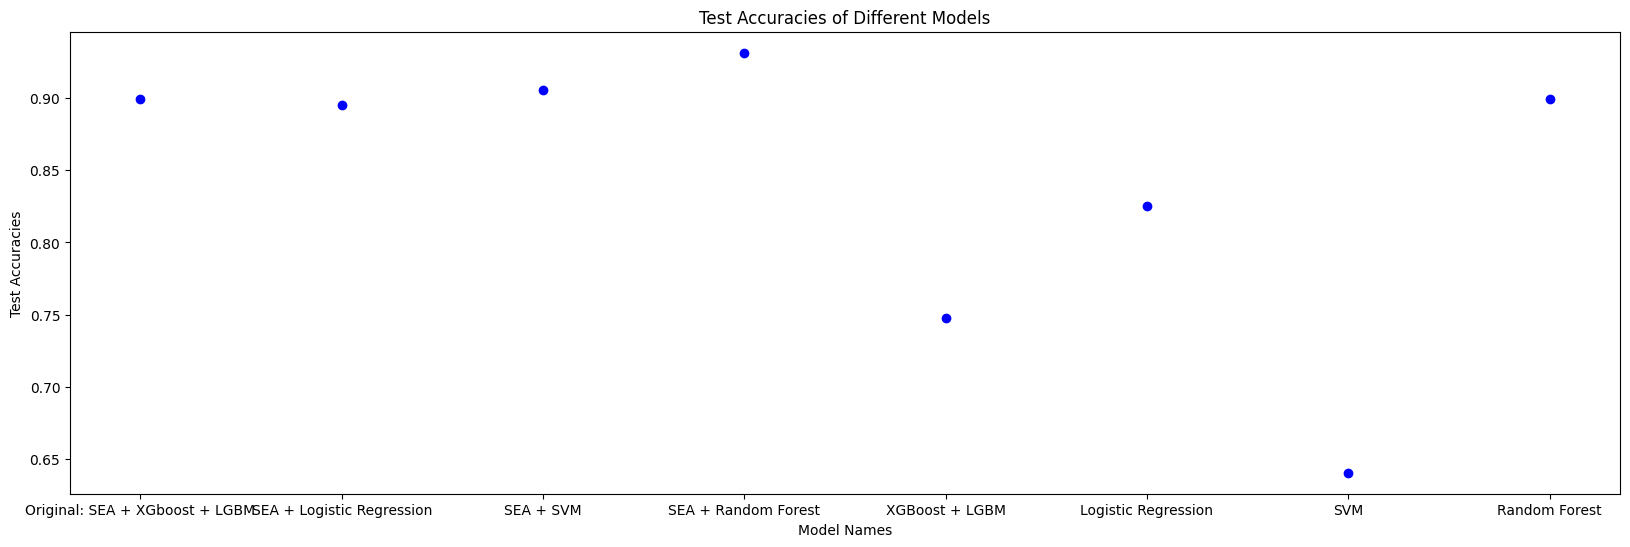

In [23]:
plt.figure(figsize=(20, 6))
# Create a scatter plot
plt.scatter(model_names, test_accs, color='blue')

# Add labels and title
plt.xlabel('Model Names')
plt.ylabel('Test Accuracies')
plt.title('Test Accuracies of Different Models')

# Show the plot
plt.show()


# Adversarial Retraining Defense

## Retraining

In [24]:
orig_test=pd.read_csv('/content/drive/MyDrive/data/result_embed.csv')
orig_test2=pd.read_csv('/content/drive/MyDrive/data/dataset.csv')
orig_test2= pd.DataFrame(orig_test['ID']).merge(orig_test2, on='ID').reset_index(drop = True)
orig_test2['Opcodes'] = orig_test2['Opcodes'].apply(lambda x: str(x).replace(',',' '))
orig_test2.drop(columns=['Family'], inplace=True)
test2 = pd.read_csv('/content/drive/MyDrive/data/appended_new_opcodes.csv')
test = pd.read_csv('/content/drive/MyDrive/data/appended_result_embed.csv')
test2= pd.DataFrame(test['ID']).merge(test2, on='ID').reset_index(drop = True)
test2.drop(columns=['Family'], inplace=True)


In [25]:
final_embed=pd.concat([orig_test, test], ignore_index=True)
final_op=pd.concat([orig_test2, test2], ignore_index=True)

In [26]:
vectorizer = TfidfVectorizer()
tf_encs = vectorizer.fit_transform(final_op['Opcodes'])
tf_encs = tf_encs.toarray()
Xx = pd.DataFrame(tf_encs)

In [27]:
final_embed= final_embed.reset_index(drop = True)
final_embed['Family'] = final_embed['Family'] - 1
final_embed.head()

,ID,Family,0,1,2,3,4,5,6,7,...,90,91,92,93,94,95,96,97,98,99
0,01kcPWA9K2BOxQeS5Rju,0,-0.338611,1.291727,0.118837,-1.118286,0.183966,-0.405247,-0.729886,-0.332307,...,-0.475346,-0.425257,-0.000070,0.276955,0.192112,1.176439,-0.234972,-0.730219,1.071440,-0.091770
1,04EjIdbPV5e1XroFOpiN,0,-0.428330,1.376984,0.234024,-0.627847,0.213055,-0.609343,-0.659496,-0.320076,...,-0.408290,-0.389868,-0.164271,0.207200,0.035918,1.313510,-0.123089,-0.806177,1.062548,-0.169090
2,05EeG39MTRrI6VY21DPd,0,-0.377473,1.542212,0.202506,-0.368294,0.447894,-0.722350,-0.336275,-0.411114,...,-0.553859,-0.478773,-0.139812,0.208929,0.004945,1.640448,-0.340988,-0.576668,1.164637,-0.100652
3,05rJTUWYAKNegBk2wE8X,0,-0.354789,1.304047,0.117015,-0.903091,0.150693,-0.642379,-0.896521,-0.305303,...,-0.351606,-0.341613,-0.220712,0.312799,0.046395,1.294530,-0.131182,-0.718261,1.172608,-0.229033
4,0AnoOZDNbPXIr2MRBSCJ,0,-0.175248,1.296375,-0.155661,-0.533257,0.156963,-0.595596,-0.341953,-0.253579,...,-0.324669,-0.036423,-0.272495,-0.101691,0.137479,1.847042,-0.233596,-0.768067,0.979953,0.340067


In [28]:
# warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=UserWarning, message=".*force_row_wise=true.*")
warnings.filterwarnings("ignore", category=UserWarning, message=".*force_col_wise=true.*")


i = 0
fold = 4
logloss_list, f1_list, recall_list, precision_list, accuracy_list = [], [], [], [], []
for tr_in, val_in in StratifiedKFold(n_splits=5, shuffle=True).split(final_embed, final_embed['Family']):
  x_train = final_embed.drop(['ID', 'Family'],axis=1).loc[tr_in, :]
  x_test = final_embed.drop(['ID', 'Family'],axis=1).loc[val_in, :]
  y_train = final_embed.loc[tr_in, 'Family']
  y_test = final_embed.loc[val_in, 'Family']

  xx_train = Xx.loc[tr_in, :]
  xx_test = Xx.loc[val_in, :]

  model = NeuralNet(100, 9).to(device)

  train_dataset = Dataset(
    x_train.values,
    y_train.values
  )
  train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=64, shuffle=True, num_workers=4
  )

  valid_dataset = Dataset(
    x_test.values,
    y_test.values
  )

  valid_loader = torch.utils.data.DataLoader(
    valid_dataset, batch_size=64, shuffle=False, num_workers=4
  )
  optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)

  lgbm = LGBMClassifier(n_jobs=-1, silent =True)
  xgb = XGBClassifier(n_jobs=-1, verbosity=0)
  logistic_reg = LogisticRegression(max_iter=100)
  svm_classifier = SVC(probability=True)
  random_forest = RandomForestClassifier(n_jobs=-1)

  lgbm.fit(xx_train.values, y_train.values)
  xgb.fit(xx_train.values, y_train.values)
  logistic_reg.fit(xx_train.values, y_train.values)
  svm_classifier.fit(xx_train.values, y_train.values)
  random_forest.fit(xx_train.values, y_train.values)

  pickle.dump(lgbm, open(f'/content/drive/MyDrive/adv_models/adv_models_lgbm/adv_lgbm_fold{i}.b5', 'wb'))
  pickle.dump(xgb, open(f'/content/drive/MyDrive/adv_models/adv_models_xgb/adv_xgb_fold{i}.b5', 'wb'))
  pickle.dump(logistic_reg, open(f'/content/drive/MyDrive/adv_models/adv_models_log/adv_logistic_reg_fold{i}.b5', 'wb'))
  pickle.dump(svm_classifier, open(f'/content/drive/MyDrive/adv_models/adv_models_svm/adv_svm_fold{i}.b5', 'wb'))
  pickle.dump(random_forest, open(f'/content/drive/MyDrive/adv_models/adv_models_rf/adv_random_forest_fold{i}.b5', 'wb'))


  best_logloss = 10
  for epoch in range(epochs):
      train_model(train_loader, model, optimizer, device=device)

      predictions, valid_targets = evaluate_model(
        valid_loader, model, device=device
      )

      lgbm_preds = lgbm.predict_proba(xx_test.values)
      xgb_preds = xgb.predict_proba(xx_test.values)

      predictions = (np.array(predictions) * 0.33 + lgbm_preds * 0.33 + xgb_preds * 0.33)

      logloss = metrics.log_loss(valid_targets, predictions)
      f1 = metrics.f1_score(valid_targets, np.array(predictions).argmax(axis=1), average='micro')
      recall = metrics.recall_score(valid_targets, np.array(predictions).argmax(axis=1), average='micro')
      precision = metrics.precision_score(valid_targets, np.array(predictions).argmax(axis=1), average='micro')
      accuracy = metrics.accuracy_score(valid_targets, np.array(predictions).argmax(axis=1))

      logloss_list.append(logloss)
      f1_list.append(f1)
      recall_list.append(recall)
      precision_list.append(precision)
      accuracy_list.append(accuracy)

      print(
        f"Epoch={epoch} \nValidation: = Logloss: {round(logloss*100,3)} F1: {round(f1*100,3)} Recall: {round(recall*100,3)} Precision: {round(precision*100,3)} Accuracy: {round(accuracy*100,3)}"
      )
      if logloss < best_logloss:
        save_checkpoint(model, optimizer, f'/content/drive/MyDrive/adv_models/adv_models_nn/adv_model_fold{i}_{epoch}.pth')
        best_logloss = logloss
  i += 1

[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.094492 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 23422
[LightGBM] [Info] Number of data points in the train set: 17388, number of used features: 96
[LightGBM] [Info] Start training from score -1.953589
[LightGBM] [Info] Start training from score -1.478274
[LightGBM] [Info] Start training from score -1.306730
[LightGBM] [Info] Start training from score -3.130217
[LightGBM] [Info] Start training from score -5.558843
[LightGBM] [Info] Start training from score -2.671793
[LightGBM] [Info] Start training from score -3.306766
[LightGBM] [Info] Start training from score -2.180288
[LightGBM] [Info] Start training from score -2.373354
[LightGBM] [Warning] No further splits with positive gain, best ga

100%|██████████| 68/68 [00:00<00:00, 81.25it/s] 


[LightGBM] [Warning] Unknown parameter: silent
Epoch=0 
Validation: = Logloss: 13.095 F1: 99.379 Recall: 99.379 Precision: 99.379 Accuracy: 99.379


100%|██████████| 68/68 [00:01<00:00, 53.68it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=1 
Validation: = Logloss: 9.669 F1: 99.356 Recall: 99.356 Precision: 99.356 Accuracy: 99.356


100%|██████████| 68/68 [00:00<00:00, 73.88it/s] 


[LightGBM] [Warning] Unknown parameter: silent
Epoch=2 
Validation: = Logloss: 9.42 F1: 99.287 Recall: 99.287 Precision: 99.287 Accuracy: 99.287


100%|██████████| 68/68 [00:00<00:00, 78.27it/s] 


[LightGBM] [Warning] Unknown parameter: silent
Epoch=3 
Validation: = Logloss: 8.953 F1: 99.356 Recall: 99.356 Precision: 99.356 Accuracy: 99.356


100%|██████████| 68/68 [00:00<00:00, 77.55it/s] 


[LightGBM] [Warning] Unknown parameter: silent
Epoch=4 
Validation: = Logloss: 8.953 F1: 99.287 Recall: 99.287 Precision: 99.287 Accuracy: 99.287


100%|██████████| 68/68 [00:00<00:00, 78.90it/s] 


[LightGBM] [Warning] Unknown parameter: silent
Epoch=5 
Validation: = Logloss: 8.813 F1: 99.356 Recall: 99.356 Precision: 99.356 Accuracy: 99.356


100%|██████████| 68/68 [00:01<00:00, 51.32it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=6 
Validation: = Logloss: 8.71 F1: 99.356 Recall: 99.356 Precision: 99.356 Accuracy: 99.356


100%|██████████| 68/68 [00:00<00:00, 80.84it/s] 


[LightGBM] [Warning] Unknown parameter: silent
Epoch=7 
Validation: = Logloss: 7.578 F1: 99.356 Recall: 99.356 Precision: 99.356 Accuracy: 99.356


100%|██████████| 68/68 [00:01<00:00, 48.39it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=8 
Validation: = Logloss: 7.484 F1: 99.31 Recall: 99.31 Precision: 99.31 Accuracy: 99.31


100%|██████████| 68/68 [00:00<00:00, 79.76it/s] 


[LightGBM] [Warning] Unknown parameter: silent
Epoch=9 
Validation: = Logloss: 7.63 F1: 99.379 Recall: 99.379 Precision: 99.379 Accuracy: 99.379


100%|██████████| 68/68 [00:01<00:00, 51.10it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=10 
Validation: = Logloss: 7.303 F1: 99.379 Recall: 99.379 Precision: 99.379 Accuracy: 99.379


100%|██████████| 68/68 [00:00<00:00, 78.61it/s] 


[LightGBM] [Warning] Unknown parameter: silent
Epoch=11 
Validation: = Logloss: 7.448 F1: 99.379 Recall: 99.379 Precision: 99.379 Accuracy: 99.379


100%|██████████| 68/68 [00:01<00:00, 60.84it/s] 


[LightGBM] [Warning] Unknown parameter: silent
Epoch=12 
Validation: = Logloss: 7.274 F1: 99.402 Recall: 99.402 Precision: 99.402 Accuracy: 99.402


100%|██████████| 68/68 [00:00<00:00, 80.57it/s] 


[LightGBM] [Warning] Unknown parameter: silent
Epoch=13 
Validation: = Logloss: 7.34 F1: 99.402 Recall: 99.402 Precision: 99.402 Accuracy: 99.402


100%|██████████| 68/68 [00:00<00:00, 78.90it/s] 


[LightGBM] [Warning] Unknown parameter: silent
Epoch=14 
Validation: = Logloss: 7.332 F1: 99.356 Recall: 99.356 Precision: 99.356 Accuracy: 99.356


100%|██████████| 68/68 [00:00<00:00, 76.67it/s] 


[LightGBM] [Warning] Unknown parameter: silent
Epoch=15 
Validation: = Logloss: 7.111 F1: 99.31 Recall: 99.31 Precision: 99.31 Accuracy: 99.31


100%|██████████| 68/68 [00:00<00:00, 79.67it/s] 


[LightGBM] [Warning] Unknown parameter: silent
Epoch=16 
Validation: = Logloss: 7.003 F1: 99.333 Recall: 99.333 Precision: 99.333 Accuracy: 99.333


100%|██████████| 68/68 [00:01<00:00, 47.92it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=17 
Validation: = Logloss: 7.035 F1: 99.356 Recall: 99.356 Precision: 99.356 Accuracy: 99.356


100%|██████████| 68/68 [00:01<00:00, 50.61it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=18 
Validation: = Logloss: 7.118 F1: 99.448 Recall: 99.448 Precision: 99.448 Accuracy: 99.448


100%|██████████| 68/68 [00:00<00:00, 78.91it/s] 


[LightGBM] [Warning] Unknown parameter: silent
Epoch=19 
Validation: = Logloss: 7.068 F1: 99.379 Recall: 99.379 Precision: 99.379 Accuracy: 99.379


100%|██████████| 68/68 [00:00<00:00, 74.71it/s] 


[LightGBM] [Warning] Unknown parameter: silent
Epoch=20 
Validation: = Logloss: 7.075 F1: 99.379 Recall: 99.379 Precision: 99.379 Accuracy: 99.379


100%|██████████| 68/68 [00:00<00:00, 79.35it/s] 


[LightGBM] [Warning] Unknown parameter: silent
Epoch=21 
Validation: = Logloss: 7.006 F1: 99.356 Recall: 99.356 Precision: 99.356 Accuracy: 99.356


100%|██████████| 68/68 [00:00<00:00, 79.27it/s] 


[LightGBM] [Warning] Unknown parameter: silent
Epoch=22 
Validation: = Logloss: 7.03 F1: 99.356 Recall: 99.356 Precision: 99.356 Accuracy: 99.356


100%|██████████| 68/68 [00:00<00:00, 79.87it/s] 


[LightGBM] [Warning] Unknown parameter: silent
Epoch=23 
Validation: = Logloss: 6.95 F1: 99.379 Recall: 99.379 Precision: 99.379 Accuracy: 99.379


100%|██████████| 68/68 [00:01<00:00, 49.59it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=24 
Validation: = Logloss: 6.948 F1: 99.356 Recall: 99.356 Precision: 99.356 Accuracy: 99.356


100%|██████████| 68/68 [00:00<00:00, 81.91it/s] 


[LightGBM] [Warning] Unknown parameter: silent
Epoch=25 
Validation: = Logloss: 6.998 F1: 99.356 Recall: 99.356 Precision: 99.356 Accuracy: 99.356


100%|██████████| 68/68 [00:01<00:00, 48.34it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=26 
Validation: = Logloss: 6.933 F1: 99.402 Recall: 99.402 Precision: 99.402 Accuracy: 99.402


100%|██████████| 68/68 [00:00<00:00, 76.89it/s] 


[LightGBM] [Warning] Unknown parameter: silent
Epoch=27 
Validation: = Logloss: 6.947 F1: 99.356 Recall: 99.356 Precision: 99.356 Accuracy: 99.356


100%|██████████| 68/68 [00:01<00:00, 48.91it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=28 
Validation: = Logloss: 6.94 F1: 99.402 Recall: 99.402 Precision: 99.402 Accuracy: 99.402


100%|██████████| 68/68 [00:00<00:00, 78.21it/s] 


[LightGBM] [Warning] Unknown parameter: silent
Epoch=29 
Validation: = Logloss: 6.901 F1: 99.379 Recall: 99.379 Precision: 99.379 Accuracy: 99.379


100%|██████████| 68/68 [00:01<00:00, 56.08it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=30 
Validation: = Logloss: 6.839 F1: 99.425 Recall: 99.425 Precision: 99.425 Accuracy: 99.425


100%|██████████| 68/68 [00:00<00:00, 78.91it/s] 


[LightGBM] [Warning] Unknown parameter: silent
Epoch=31 
Validation: = Logloss: 6.89 F1: 99.379 Recall: 99.379 Precision: 99.379 Accuracy: 99.379


100%|██████████| 68/68 [00:00<00:00, 80.26it/s] 


[LightGBM] [Warning] Unknown parameter: silent
Epoch=32 
Validation: = Logloss: 7.02 F1: 99.356 Recall: 99.356 Precision: 99.356 Accuracy: 99.356


100%|██████████| 68/68 [00:00<00:00, 80.22it/s] 


[LightGBM] [Warning] Unknown parameter: silent
Epoch=33 
Validation: = Logloss: 6.857 F1: 99.402 Recall: 99.402 Precision: 99.402 Accuracy: 99.402


100%|██████████| 68/68 [00:00<00:00, 74.62it/s] 


[LightGBM] [Warning] Unknown parameter: silent
Epoch=34 
Validation: = Logloss: 7.093 F1: 99.356 Recall: 99.356 Precision: 99.356 Accuracy: 99.356


100%|██████████| 68/68 [00:01<00:00, 63.14it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=35 
Validation: = Logloss: 6.812 F1: 99.379 Recall: 99.379 Precision: 99.379 Accuracy: 99.379


100%|██████████| 68/68 [00:00<00:00, 80.29it/s] 


[LightGBM] [Warning] Unknown parameter: silent
Epoch=36 
Validation: = Logloss: 6.879 F1: 99.402 Recall: 99.402 Precision: 99.402 Accuracy: 99.402


100%|██████████| 68/68 [00:01<00:00, 49.53it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=37 
Validation: = Logloss: 6.942 F1: 99.379 Recall: 99.379 Precision: 99.379 Accuracy: 99.379


100%|██████████| 68/68 [00:00<00:00, 78.42it/s] 


[LightGBM] [Warning] Unknown parameter: silent
Epoch=38 
Validation: = Logloss: 6.816 F1: 99.356 Recall: 99.356 Precision: 99.356 Accuracy: 99.356


100%|██████████| 68/68 [00:01<00:00, 49.37it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=39 
Validation: = Logloss: 6.851 F1: 99.402 Recall: 99.402 Precision: 99.402 Accuracy: 99.402


100%|██████████| 68/68 [00:00<00:00, 80.27it/s] 


[LightGBM] [Warning] Unknown parameter: silent
Epoch=40 
Validation: = Logloss: 6.952 F1: 99.379 Recall: 99.379 Precision: 99.379 Accuracy: 99.379


100%|██████████| 68/68 [00:01<00:00, 47.67it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=41 
Validation: = Logloss: 6.85 F1: 99.379 Recall: 99.379 Precision: 99.379 Accuracy: 99.379


100%|██████████| 68/68 [00:00<00:00, 80.85it/s] 


[LightGBM] [Warning] Unknown parameter: silent
Epoch=42 
Validation: = Logloss: 6.892 F1: 99.356 Recall: 99.356 Precision: 99.356 Accuracy: 99.356


100%|██████████| 68/68 [00:01<00:00, 54.64it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=43 
Validation: = Logloss: 6.835 F1: 99.402 Recall: 99.402 Precision: 99.402 Accuracy: 99.402


100%|██████████| 68/68 [00:00<00:00, 78.85it/s] 


[LightGBM] [Warning] Unknown parameter: silent
Epoch=44 
Validation: = Logloss: 6.833 F1: 99.379 Recall: 99.379 Precision: 99.379 Accuracy: 99.379


100%|██████████| 68/68 [00:00<00:00, 75.68it/s] 


[LightGBM] [Warning] Unknown parameter: silent
Epoch=45 
Validation: = Logloss: 6.992 F1: 99.379 Recall: 99.379 Precision: 99.379 Accuracy: 99.379


100%|██████████| 68/68 [00:00<00:00, 79.10it/s] 


[LightGBM] [Warning] Unknown parameter: silent
Epoch=46 
Validation: = Logloss: 6.781 F1: 99.402 Recall: 99.402 Precision: 99.402 Accuracy: 99.402


100%|██████████| 68/68 [00:00<00:00, 79.50it/s] 


[LightGBM] [Warning] Unknown parameter: silent
Epoch=47 
Validation: = Logloss: 6.888 F1: 99.333 Recall: 99.333 Precision: 99.333 Accuracy: 99.333


100%|██████████| 68/68 [00:00<00:00, 79.70it/s] 


[LightGBM] [Warning] Unknown parameter: silent
Epoch=48 
Validation: = Logloss: 6.594 F1: 99.402 Recall: 99.402 Precision: 99.402 Accuracy: 99.402


100%|██████████| 68/68 [00:00<00:00, 80.62it/s] 


[LightGBM] [Warning] Unknown parameter: silent
Epoch=49 
Validation: = Logloss: 6.594 F1: 99.356 Recall: 99.356 Precision: 99.356 Accuracy: 99.356
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012492 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 23436
[LightGBM] [Info] Number of data points in the train set: 17389, number of used features: 96
[LightGBM] [Info] Start training from score -1.953646
[LightGBM] [Info] Start training from score -1.478332
[LightGBM] [Info] Start training from score -1.306787
[LightGBM] [Info] Start training from score -3.130275
[LightGBM] [Info] Start training from score -5.544085
[LightGBM] [Info] Start training from score -2.672683
[LightGBM] [Info] Start training from score -3.306823
[LightGBM] [Info] Start tra

100%|██████████| 68/68 [00:00<00:00, 77.77it/s] 


[LightGBM] [Warning] Unknown parameter: silent
Epoch=0 
Validation: = Logloss: 12.751 F1: 99.54 Recall: 99.54 Precision: 99.54 Accuracy: 99.54


100%|██████████| 68/68 [00:01<00:00, 49.69it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=1 
Validation: = Logloss: 12.198 F1: 99.54 Recall: 99.54 Precision: 99.54 Accuracy: 99.54


100%|██████████| 68/68 [00:01<00:00, 48.32it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=2 
Validation: = Logloss: 8.666 F1: 99.54 Recall: 99.54 Precision: 99.54 Accuracy: 99.54


100%|██████████| 68/68 [00:00<00:00, 79.55it/s] 


[LightGBM] [Warning] Unknown parameter: silent
Epoch=3 
Validation: = Logloss: 8.33 F1: 99.563 Recall: 99.563 Precision: 99.563 Accuracy: 99.563


100%|██████████| 68/68 [00:00<00:00, 76.86it/s] 


[LightGBM] [Warning] Unknown parameter: silent
Epoch=4 
Validation: = Logloss: 8.436 F1: 99.54 Recall: 99.54 Precision: 99.54 Accuracy: 99.54


100%|██████████| 68/68 [00:00<00:00, 77.02it/s] 


[LightGBM] [Warning] Unknown parameter: silent
Epoch=5 
Validation: = Logloss: 8.22 F1: 99.54 Recall: 99.54 Precision: 99.54 Accuracy: 99.54


100%|██████████| 68/68 [00:00<00:00, 78.27it/s] 


[LightGBM] [Warning] Unknown parameter: silent
Epoch=6 
Validation: = Logloss: 6.978 F1: 99.563 Recall: 99.563 Precision: 99.563 Accuracy: 99.563


100%|██████████| 68/68 [00:00<00:00, 78.34it/s] 


[LightGBM] [Warning] Unknown parameter: silent
Epoch=7 
Validation: = Logloss: 6.711 F1: 99.586 Recall: 99.586 Precision: 99.586 Accuracy: 99.586


100%|██████████| 68/68 [00:01<00:00, 50.76it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=8 
Validation: = Logloss: 6.791 F1: 99.494 Recall: 99.494 Precision: 99.494 Accuracy: 99.494


100%|██████████| 68/68 [00:00<00:00, 78.87it/s] 


[LightGBM] [Warning] Unknown parameter: silent
Epoch=9 
Validation: = Logloss: 6.601 F1: 99.517 Recall: 99.517 Precision: 99.517 Accuracy: 99.517


100%|██████████| 68/68 [00:01<00:00, 50.55it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=10 
Validation: = Logloss: 6.446 F1: 99.563 Recall: 99.563 Precision: 99.563 Accuracy: 99.563


100%|██████████| 68/68 [00:00<00:00, 77.47it/s] 


[LightGBM] [Warning] Unknown parameter: silent
Epoch=11 
Validation: = Logloss: 6.805 F1: 99.517 Recall: 99.517 Precision: 99.517 Accuracy: 99.517


100%|██████████| 68/68 [00:01<00:00, 51.13it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=12 
Validation: = Logloss: 6.51 F1: 99.586 Recall: 99.586 Precision: 99.586 Accuracy: 99.586


100%|██████████| 68/68 [00:00<00:00, 69.91it/s] 


[LightGBM] [Warning] Unknown parameter: silent
Epoch=13 
Validation: = Logloss: 6.568 F1: 99.563 Recall: 99.563 Precision: 99.563 Accuracy: 99.563


100%|██████████| 68/68 [00:00<00:00, 78.68it/s] 


[LightGBM] [Warning] Unknown parameter: silent
Epoch=14 
Validation: = Logloss: 6.459 F1: 99.586 Recall: 99.586 Precision: 99.586 Accuracy: 99.586


100%|██████████| 68/68 [00:00<00:00, 76.62it/s] 


[LightGBM] [Warning] Unknown parameter: silent
Epoch=15 
Validation: = Logloss: 6.605 F1: 99.586 Recall: 99.586 Precision: 99.586 Accuracy: 99.586


100%|██████████| 68/68 [00:00<00:00, 78.96it/s] 


[LightGBM] [Warning] Unknown parameter: silent
Epoch=16 
Validation: = Logloss: 6.373 F1: 99.563 Recall: 99.563 Precision: 99.563 Accuracy: 99.563


100%|██████████| 68/68 [00:01<00:00, 45.18it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=17 
Validation: = Logloss: 6.399 F1: 99.563 Recall: 99.563 Precision: 99.563 Accuracy: 99.563


100%|██████████| 68/68 [00:00<00:00, 78.15it/s] 


[LightGBM] [Warning] Unknown parameter: silent
Epoch=18 
Validation: = Logloss: 6.287 F1: 99.563 Recall: 99.563 Precision: 99.563 Accuracy: 99.563


100%|██████████| 68/68 [00:01<00:00, 48.40it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=19 
Validation: = Logloss: 6.244 F1: 99.563 Recall: 99.563 Precision: 99.563 Accuracy: 99.563


100%|██████████| 68/68 [00:00<00:00, 77.84it/s] 


[LightGBM] [Warning] Unknown parameter: silent
Epoch=20 
Validation: = Logloss: 6.179 F1: 99.586 Recall: 99.586 Precision: 99.586 Accuracy: 99.586


100%|██████████| 68/68 [00:01<00:00, 48.68it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=21 
Validation: = Logloss: 6.338 F1: 99.586 Recall: 99.586 Precision: 99.586 Accuracy: 99.586


100%|██████████| 68/68 [00:00<00:00, 78.30it/s] 


[LightGBM] [Warning] Unknown parameter: silent
Epoch=22 
Validation: = Logloss: 6.409 F1: 99.609 Recall: 99.609 Precision: 99.609 Accuracy: 99.609


100%|██████████| 68/68 [00:01<00:00, 51.13it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=23 
Validation: = Logloss: 6.143 F1: 99.609 Recall: 99.609 Precision: 99.609 Accuracy: 99.609


100%|██████████| 68/68 [00:00<00:00, 78.31it/s] 


[LightGBM] [Warning] Unknown parameter: silent
Epoch=24 
Validation: = Logloss: 6.179 F1: 99.609 Recall: 99.609 Precision: 99.609 Accuracy: 99.609


100%|██████████| 68/68 [00:00<00:00, 76.59it/s] 


[LightGBM] [Warning] Unknown parameter: silent
Epoch=25 
Validation: = Logloss: 6.058 F1: 99.609 Recall: 99.609 Precision: 99.609 Accuracy: 99.609


100%|██████████| 68/68 [00:00<00:00, 75.87it/s] 


[LightGBM] [Warning] Unknown parameter: silent
Epoch=26 
Validation: = Logloss: 6.288 F1: 99.609 Recall: 99.609 Precision: 99.609 Accuracy: 99.609


100%|██████████| 68/68 [00:00<00:00, 77.47it/s] 


[LightGBM] [Warning] Unknown parameter: silent
Epoch=27 
Validation: = Logloss: 6.098 F1: 99.609 Recall: 99.609 Precision: 99.609 Accuracy: 99.609


100%|██████████| 68/68 [00:00<00:00, 75.58it/s] 


[LightGBM] [Warning] Unknown parameter: silent
Epoch=28 
Validation: = Logloss: 6.048 F1: 99.609 Recall: 99.609 Precision: 99.609 Accuracy: 99.609


100%|██████████| 68/68 [00:01<00:00, 58.81it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=29 
Validation: = Logloss: 6.1 F1: 99.609 Recall: 99.609 Precision: 99.609 Accuracy: 99.609


100%|██████████| 68/68 [00:00<00:00, 75.87it/s] 


[LightGBM] [Warning] Unknown parameter: silent
Epoch=30 
Validation: = Logloss: 6.094 F1: 99.609 Recall: 99.609 Precision: 99.609 Accuracy: 99.609


100%|██████████| 68/68 [00:00<00:00, 79.63it/s] 


[LightGBM] [Warning] Unknown parameter: silent
Epoch=31 
Validation: = Logloss: 6.178 F1: 99.609 Recall: 99.609 Precision: 99.609 Accuracy: 99.609


100%|██████████| 68/68 [00:01<00:00, 47.32it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=32 
Validation: = Logloss: 6.192 F1: 99.609 Recall: 99.609 Precision: 99.609 Accuracy: 99.609


100%|██████████| 68/68 [00:00<00:00, 77.84it/s] 


[LightGBM] [Warning] Unknown parameter: silent
Epoch=33 
Validation: = Logloss: 6.014 F1: 99.609 Recall: 99.609 Precision: 99.609 Accuracy: 99.609


100%|██████████| 68/68 [00:01<00:00, 49.55it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=34 
Validation: = Logloss: 5.768 F1: 99.609 Recall: 99.609 Precision: 99.609 Accuracy: 99.609


100%|██████████| 68/68 [00:00<00:00, 77.40it/s] 


[LightGBM] [Warning] Unknown parameter: silent
Epoch=35 
Validation: = Logloss: 5.835 F1: 99.609 Recall: 99.609 Precision: 99.609 Accuracy: 99.609


100%|██████████| 68/68 [00:01<00:00, 54.81it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=36 
Validation: = Logloss: 5.869 F1: 99.609 Recall: 99.609 Precision: 99.609 Accuracy: 99.609


100%|██████████| 68/68 [00:00<00:00, 76.88it/s] 


[LightGBM] [Warning] Unknown parameter: silent
Epoch=37 
Validation: = Logloss: 5.83 F1: 99.609 Recall: 99.609 Precision: 99.609 Accuracy: 99.609


100%|██████████| 68/68 [00:00<00:00, 75.90it/s] 


[LightGBM] [Warning] Unknown parameter: silent
Epoch=38 
Validation: = Logloss: 5.959 F1: 99.609 Recall: 99.609 Precision: 99.609 Accuracy: 99.609


100%|██████████| 68/68 [00:00<00:00, 77.36it/s] 


[LightGBM] [Warning] Unknown parameter: silent
Epoch=39 
Validation: = Logloss: 5.877 F1: 99.609 Recall: 99.609 Precision: 99.609 Accuracy: 99.609


100%|██████████| 68/68 [00:00<00:00, 77.57it/s] 


[LightGBM] [Warning] Unknown parameter: silent
Epoch=40 
Validation: = Logloss: 6.061 F1: 99.609 Recall: 99.609 Precision: 99.609 Accuracy: 99.609


100%|██████████| 68/68 [00:00<00:00, 76.33it/s] 


[LightGBM] [Warning] Unknown parameter: silent
Epoch=41 
Validation: = Logloss: 5.84 F1: 99.609 Recall: 99.609 Precision: 99.609 Accuracy: 99.609


100%|██████████| 68/68 [00:00<00:00, 75.65it/s] 


[LightGBM] [Warning] Unknown parameter: silent
Epoch=42 
Validation: = Logloss: 5.718 F1: 99.609 Recall: 99.609 Precision: 99.609 Accuracy: 99.609


100%|██████████| 68/68 [00:01<00:00, 50.43it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=43 
Validation: = Logloss: 5.825 F1: 99.609 Recall: 99.609 Precision: 99.609 Accuracy: 99.609


100%|██████████| 68/68 [00:00<00:00, 76.76it/s] 


[LightGBM] [Warning] Unknown parameter: silent
Epoch=44 
Validation: = Logloss: 5.888 F1: 99.609 Recall: 99.609 Precision: 99.609 Accuracy: 99.609


100%|██████████| 68/68 [00:01<00:00, 50.61it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=45 
Validation: = Logloss: 5.983 F1: 99.609 Recall: 99.609 Precision: 99.609 Accuracy: 99.609


100%|██████████| 68/68 [00:00<00:00, 78.43it/s] 


[LightGBM] [Warning] Unknown parameter: silent
Epoch=46 
Validation: = Logloss: 5.952 F1: 99.609 Recall: 99.609 Precision: 99.609 Accuracy: 99.609


100%|██████████| 68/68 [00:01<00:00, 48.86it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=47 
Validation: = Logloss: 5.817 F1: 99.609 Recall: 99.609 Precision: 99.609 Accuracy: 99.609


100%|██████████| 68/68 [00:00<00:00, 75.31it/s] 


[LightGBM] [Warning] Unknown parameter: silent
Epoch=48 
Validation: = Logloss: 5.794 F1: 99.609 Recall: 99.609 Precision: 99.609 Accuracy: 99.609


100%|██████████| 68/68 [00:01<00:00, 67.99it/s] 


[LightGBM] [Warning] Unknown parameter: silent
Epoch=49 
Validation: = Logloss: 5.963 F1: 99.586 Recall: 99.586 Precision: 99.586 Accuracy: 99.586
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022955 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 23429
[LightGBM] [Info] Number of data points in the train set: 17389, number of used features: 96
[LightGBM] [Info] Start training from score -1.953240
[LightGBM] [Info] Start training from score -1.478584
[LightGBM] [Info] Start training from score -1.306575
[LightGBM] [Info] Start training from score -3.130275
[LightGBM] [Info] Start training from score -5.558900
[LightGBM] [Info] Start training from score -2.672683
[LightGBM] [Info] Start training from score -3.306823
[LightGBM] [Info] Start training from score -2.180346
[LightGBM] [Info] Start training from

100%|██████████| 68/68 [00:01<00:00, 47.31it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=0 
Validation: = Logloss: 10.406 F1: 99.31 Recall: 99.31 Precision: 99.31 Accuracy: 99.31


100%|██████████| 68/68 [00:00<00:00, 76.24it/s] 


[LightGBM] [Warning] Unknown parameter: silent
Epoch=1 
Validation: = Logloss: 9.329 F1: 99.333 Recall: 99.333 Precision: 99.333 Accuracy: 99.333


100%|██████████| 68/68 [00:01<00:00, 45.13it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=2 
Validation: = Logloss: 9.466 F1: 99.333 Recall: 99.333 Precision: 99.333 Accuracy: 99.333


100%|██████████| 68/68 [00:02<00:00, 30.01it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=3 
Validation: = Logloss: 9.004 F1: 99.333 Recall: 99.333 Precision: 99.333 Accuracy: 99.333


100%|██████████| 68/68 [00:00<00:00, 74.95it/s] 


[LightGBM] [Warning] Unknown parameter: silent
Epoch=4 
Validation: = Logloss: 8.94 F1: 99.333 Recall: 99.333 Precision: 99.333 Accuracy: 99.333


100%|██████████| 68/68 [00:00<00:00, 76.91it/s] 


[LightGBM] [Warning] Unknown parameter: silent
Epoch=5 
Validation: = Logloss: 8.776 F1: 99.218 Recall: 99.218 Precision: 99.218 Accuracy: 99.218


100%|██████████| 68/68 [00:01<00:00, 46.78it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=6 
Validation: = Logloss: 8.699 F1: 99.31 Recall: 99.31 Precision: 99.31 Accuracy: 99.31


100%|██████████| 68/68 [00:00<00:00, 75.10it/s] 


[LightGBM] [Warning] Unknown parameter: silent
Epoch=7 
Validation: = Logloss: 8.669 F1: 99.31 Recall: 99.31 Precision: 99.31 Accuracy: 99.31


100%|██████████| 68/68 [00:01<00:00, 49.00it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=8 
Validation: = Logloss: 8.668 F1: 99.31 Recall: 99.31 Precision: 99.31 Accuracy: 99.31


100%|██████████| 68/68 [00:01<00:00, 49.55it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=9 
Validation: = Logloss: 7.457 F1: 99.31 Recall: 99.31 Precision: 99.31 Accuracy: 99.31


100%|██████████| 68/68 [00:00<00:00, 77.40it/s] 


[LightGBM] [Warning] Unknown parameter: silent
Epoch=10 
Validation: = Logloss: 7.525 F1: 99.31 Recall: 99.31 Precision: 99.31 Accuracy: 99.31


100%|██████████| 68/68 [00:00<00:00, 75.63it/s] 


[LightGBM] [Warning] Unknown parameter: silent
Epoch=11 
Validation: = Logloss: 7.333 F1: 99.287 Recall: 99.287 Precision: 99.287 Accuracy: 99.287


100%|██████████| 68/68 [00:01<00:00, 39.95it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=12 
Validation: = Logloss: 7.394 F1: 99.333 Recall: 99.333 Precision: 99.333 Accuracy: 99.333


100%|██████████| 68/68 [00:01<00:00, 52.63it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=13 
Validation: = Logloss: 7.203 F1: 99.31 Recall: 99.31 Precision: 99.31 Accuracy: 99.31


100%|██████████| 68/68 [00:02<00:00, 31.73it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=14 
Validation: = Logloss: 7.059 F1: 99.31 Recall: 99.31 Precision: 99.31 Accuracy: 99.31


100%|██████████| 68/68 [00:02<00:00, 27.73it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=15 
Validation: = Logloss: 7.031 F1: 99.31 Recall: 99.31 Precision: 99.31 Accuracy: 99.31


100%|██████████| 68/68 [00:01<00:00, 61.00it/s] 


[LightGBM] [Warning] Unknown parameter: silent
Epoch=16 
Validation: = Logloss: 7.064 F1: 99.31 Recall: 99.31 Precision: 99.31 Accuracy: 99.31


100%|██████████| 68/68 [00:00<00:00, 76.51it/s] 


[LightGBM] [Warning] Unknown parameter: silent
Epoch=17 
Validation: = Logloss: 7.061 F1: 99.172 Recall: 99.172 Precision: 99.172 Accuracy: 99.172


100%|██████████| 68/68 [00:00<00:00, 76.31it/s] 


[LightGBM] [Warning] Unknown parameter: silent
Epoch=18 
Validation: = Logloss: 7.049 F1: 99.287 Recall: 99.287 Precision: 99.287 Accuracy: 99.287


100%|██████████| 68/68 [00:00<00:00, 76.44it/s] 


[LightGBM] [Warning] Unknown parameter: silent
Epoch=19 
Validation: = Logloss: 7.09 F1: 99.333 Recall: 99.333 Precision: 99.333 Accuracy: 99.333


100%|██████████| 68/68 [00:00<00:00, 71.09it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=20 
Validation: = Logloss: 6.997 F1: 99.31 Recall: 99.31 Precision: 99.31 Accuracy: 99.31


100%|██████████| 68/68 [00:01<00:00, 41.29it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=21 
Validation: = Logloss: 6.97 F1: 99.333 Recall: 99.333 Precision: 99.333 Accuracy: 99.333


100%|██████████| 68/68 [00:01<00:00, 43.08it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=22 
Validation: = Logloss: 7.004 F1: 99.31 Recall: 99.31 Precision: 99.31 Accuracy: 99.31


100%|██████████| 68/68 [00:01<00:00, 44.19it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=23 
Validation: = Logloss: 6.939 F1: 99.31 Recall: 99.31 Precision: 99.31 Accuracy: 99.31


100%|██████████| 68/68 [00:02<00:00, 28.58it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=24 
Validation: = Logloss: 7.038 F1: 99.287 Recall: 99.287 Precision: 99.287 Accuracy: 99.287


100%|██████████| 68/68 [00:01<00:00, 35.48it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=25 
Validation: = Logloss: 6.604 F1: 99.31 Recall: 99.31 Precision: 99.31 Accuracy: 99.31


100%|██████████| 68/68 [00:02<00:00, 31.93it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=26 
Validation: = Logloss: 6.618 F1: 99.287 Recall: 99.287 Precision: 99.287 Accuracy: 99.287


100%|██████████| 68/68 [00:01<00:00, 40.73it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=27 
Validation: = Logloss: 6.716 F1: 99.287 Recall: 99.287 Precision: 99.287 Accuracy: 99.287


100%|██████████| 68/68 [00:00<00:00, 75.23it/s] 


[LightGBM] [Warning] Unknown parameter: silent
Epoch=28 
Validation: = Logloss: 4.738 F1: 99.287 Recall: 99.287 Precision: 99.287 Accuracy: 99.287


100%|██████████| 68/68 [00:02<00:00, 30.72it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=29 
Validation: = Logloss: 4.674 F1: 99.31 Recall: 99.31 Precision: 99.31 Accuracy: 99.31


100%|██████████| 68/68 [00:01<00:00, 57.40it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=30 
Validation: = Logloss: 4.659 F1: 99.31 Recall: 99.31 Precision: 99.31 Accuracy: 99.31


100%|██████████| 68/68 [00:01<00:00, 55.85it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=31 
Validation: = Logloss: 4.878 F1: 99.287 Recall: 99.287 Precision: 99.287 Accuracy: 99.287


100%|██████████| 68/68 [00:00<00:00, 74.33it/s] 


[LightGBM] [Warning] Unknown parameter: silent
Epoch=32 
Validation: = Logloss: 4.647 F1: 99.31 Recall: 99.31 Precision: 99.31 Accuracy: 99.31


100%|██████████| 68/68 [00:01<00:00, 37.79it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=33 
Validation: = Logloss: 5.126 F1: 99.172 Recall: 99.172 Precision: 99.172 Accuracy: 99.172


100%|██████████| 68/68 [00:00<00:00, 72.78it/s] 


[LightGBM] [Warning] Unknown parameter: silent
Epoch=34 
Validation: = Logloss: 4.738 F1: 99.31 Recall: 99.31 Precision: 99.31 Accuracy: 99.31


100%|██████████| 68/68 [00:02<00:00, 32.47it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=35 
Validation: = Logloss: 4.862 F1: 99.287 Recall: 99.287 Precision: 99.287 Accuracy: 99.287


100%|██████████| 68/68 [00:00<00:00, 74.70it/s] 


[LightGBM] [Warning] Unknown parameter: silent
Epoch=36 
Validation: = Logloss: 4.695 F1: 99.287 Recall: 99.287 Precision: 99.287 Accuracy: 99.287


100%|██████████| 68/68 [00:01<00:00, 48.59it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=37 
Validation: = Logloss: 4.65 F1: 99.31 Recall: 99.31 Precision: 99.31 Accuracy: 99.31


100%|██████████| 68/68 [00:00<00:00, 74.57it/s] 


[LightGBM] [Warning] Unknown parameter: silent
Epoch=38 
Validation: = Logloss: 4.546 F1: 99.287 Recall: 99.287 Precision: 99.287 Accuracy: 99.287


100%|██████████| 68/68 [00:01<00:00, 48.16it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=39 
Validation: = Logloss: 4.692 F1: 99.333 Recall: 99.333 Precision: 99.333 Accuracy: 99.333


100%|██████████| 68/68 [00:00<00:00, 75.99it/s] 


[LightGBM] [Warning] Unknown parameter: silent
Epoch=40 
Validation: = Logloss: 4.573 F1: 99.31 Recall: 99.31 Precision: 99.31 Accuracy: 99.31


100%|██████████| 68/68 [00:00<00:00, 74.91it/s] 


[LightGBM] [Warning] Unknown parameter: silent
Epoch=41 
Validation: = Logloss: 4.693 F1: 99.31 Recall: 99.31 Precision: 99.31 Accuracy: 99.31


100%|██████████| 68/68 [00:00<00:00, 75.52it/s] 


[LightGBM] [Warning] Unknown parameter: silent
Epoch=42 
Validation: = Logloss: 4.892 F1: 99.31 Recall: 99.31 Precision: 99.31 Accuracy: 99.31


100%|██████████| 68/68 [00:00<00:00, 76.18it/s] 


[LightGBM] [Warning] Unknown parameter: silent
Epoch=43 
Validation: = Logloss: 4.765 F1: 99.31 Recall: 99.31 Precision: 99.31 Accuracy: 99.31


100%|██████████| 68/68 [00:01<00:00, 47.90it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=44 
Validation: = Logloss: 4.613 F1: 99.333 Recall: 99.333 Precision: 99.333 Accuracy: 99.333


100%|██████████| 68/68 [00:00<00:00, 73.11it/s] 


[LightGBM] [Warning] Unknown parameter: silent
Epoch=45 
Validation: = Logloss: 4.859 F1: 99.287 Recall: 99.287 Precision: 99.287 Accuracy: 99.287


100%|██████████| 68/68 [00:01<00:00, 45.62it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=46 
Validation: = Logloss: 4.608 F1: 99.31 Recall: 99.31 Precision: 99.31 Accuracy: 99.31


100%|██████████| 68/68 [00:00<00:00, 75.29it/s] 


[LightGBM] [Warning] Unknown parameter: silent
Epoch=47 
Validation: = Logloss: 4.663 F1: 99.31 Recall: 99.31 Precision: 99.31 Accuracy: 99.31


100%|██████████| 68/68 [00:00<00:00, 72.60it/s] 


[LightGBM] [Warning] Unknown parameter: silent
Epoch=48 
Validation: = Logloss: 4.606 F1: 99.31 Recall: 99.31 Precision: 99.31 Accuracy: 99.31


100%|██████████| 68/68 [00:01<00:00, 46.06it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=49 
Validation: = Logloss: 4.727 F1: 99.149 Recall: 99.149 Precision: 99.149 Accuracy: 99.149
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.049082 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 23428
[LightGBM] [Info] Number of data points in the train set: 17389, number of used features: 96
[LightGBM] [Info] Start training from score -1.953240
[LightGBM] [Info] Start training from score -1.478332
[LightGBM] [Info] Start training from score -1.306787
[LightGBM] [Info] Start training from score -3.130275
[LightGBM] [Info] Start training from score -5.558900
[LightGBM] [Info] Start training from score -2.671851
[LightGBM] [Info] Start training from score -3.308395
[LightGBM] [Info] Start tra

100%|██████████| 68/68 [00:01<00:00, 47.18it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=0 
Validation: = Logloss: 13.581 F1: 99.103 Recall: 99.103 Precision: 99.103 Accuracy: 99.103


100%|██████████| 68/68 [00:00<00:00, 71.60it/s] 


[LightGBM] [Warning] Unknown parameter: silent
Epoch=1 
Validation: = Logloss: 9.934 F1: 99.172 Recall: 99.172 Precision: 99.172 Accuracy: 99.172


100%|██████████| 68/68 [00:01<00:00, 49.01it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=2 
Validation: = Logloss: 9.555 F1: 99.149 Recall: 99.149 Precision: 99.149 Accuracy: 99.149


100%|██████████| 68/68 [00:01<00:00, 49.86it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=3 
Validation: = Logloss: 9.357 F1: 99.149 Recall: 99.149 Precision: 99.149 Accuracy: 99.149


100%|██████████| 68/68 [00:00<00:00, 74.56it/s] 


[LightGBM] [Warning] Unknown parameter: silent
Epoch=4 
Validation: = Logloss: 9.364 F1: 99.149 Recall: 99.149 Precision: 99.149 Accuracy: 99.149


100%|██████████| 68/68 [00:01<00:00, 45.14it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=5 
Validation: = Logloss: 9.351 F1: 99.172 Recall: 99.172 Precision: 99.172 Accuracy: 99.172


100%|██████████| 68/68 [00:00<00:00, 73.22it/s] 


[LightGBM] [Warning] Unknown parameter: silent
Epoch=6 
Validation: = Logloss: 9.223 F1: 99.149 Recall: 99.149 Precision: 99.149 Accuracy: 99.149


100%|██████████| 68/68 [00:01<00:00, 47.16it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=7 
Validation: = Logloss: 9.085 F1: 99.172 Recall: 99.172 Precision: 99.172 Accuracy: 99.172


100%|██████████| 68/68 [00:00<00:00, 73.44it/s] 


[LightGBM] [Warning] Unknown parameter: silent
Epoch=8 
Validation: = Logloss: 8.994 F1: 99.172 Recall: 99.172 Precision: 99.172 Accuracy: 99.172


100%|██████████| 68/68 [00:00<00:00, 74.74it/s] 


[LightGBM] [Warning] Unknown parameter: silent
Epoch=9 
Validation: = Logloss: 8.123 F1: 99.149 Recall: 99.149 Precision: 99.149 Accuracy: 99.149


100%|██████████| 68/68 [00:00<00:00, 75.07it/s] 


[LightGBM] [Warning] Unknown parameter: silent
Epoch=10 
Validation: = Logloss: 7.849 F1: 99.149 Recall: 99.149 Precision: 99.149 Accuracy: 99.149


100%|██████████| 68/68 [00:00<00:00, 74.06it/s] 


[LightGBM] [Warning] Unknown parameter: silent
Epoch=11 
Validation: = Logloss: 7.699 F1: 99.195 Recall: 99.195 Precision: 99.195 Accuracy: 99.195


100%|██████████| 68/68 [00:01<00:00, 51.75it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=12 
Validation: = Logloss: 7.811 F1: 99.149 Recall: 99.149 Precision: 99.149 Accuracy: 99.149


100%|██████████| 68/68 [00:00<00:00, 74.46it/s] 


[LightGBM] [Warning] Unknown parameter: silent
Epoch=13 
Validation: = Logloss: 7.603 F1: 99.195 Recall: 99.195 Precision: 99.195 Accuracy: 99.195


100%|██████████| 68/68 [00:01<00:00, 47.95it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=14 
Validation: = Logloss: 7.6 F1: 99.218 Recall: 99.218 Precision: 99.218 Accuracy: 99.218


100%|██████████| 68/68 [00:00<00:00, 72.78it/s] 


[LightGBM] [Warning] Unknown parameter: silent
Epoch=15 
Validation: = Logloss: 7.72 F1: 99.172 Recall: 99.172 Precision: 99.172 Accuracy: 99.172


100%|██████████| 68/68 [00:01<00:00, 47.95it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=16 
Validation: = Logloss: 7.478 F1: 99.241 Recall: 99.241 Precision: 99.241 Accuracy: 99.241


100%|██████████| 68/68 [00:00<00:00, 75.70it/s] 


[LightGBM] [Warning] Unknown parameter: silent
Epoch=17 
Validation: = Logloss: 7.604 F1: 99.195 Recall: 99.195 Precision: 99.195 Accuracy: 99.195


100%|██████████| 68/68 [00:00<00:00, 75.40it/s] 


[LightGBM] [Warning] Unknown parameter: silent
Epoch=18 
Validation: = Logloss: 7.554 F1: 99.218 Recall: 99.218 Precision: 99.218 Accuracy: 99.218


100%|██████████| 68/68 [00:00<00:00, 74.22it/s] 


[LightGBM] [Warning] Unknown parameter: silent
Epoch=19 
Validation: = Logloss: 7.456 F1: 99.264 Recall: 99.264 Precision: 99.264 Accuracy: 99.264


100%|██████████| 68/68 [00:00<00:00, 75.71it/s] 


[LightGBM] [Warning] Unknown parameter: silent
Epoch=20 
Validation: = Logloss: 7.712 F1: 99.195 Recall: 99.195 Precision: 99.195 Accuracy: 99.195


100%|██████████| 68/68 [00:01<00:00, 61.31it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=21 
Validation: = Logloss: 7.48 F1: 99.218 Recall: 99.218 Precision: 99.218 Accuracy: 99.218


100%|██████████| 68/68 [00:00<00:00, 77.90it/s] 


[LightGBM] [Warning] Unknown parameter: silent
Epoch=22 
Validation: = Logloss: 7.44 F1: 99.264 Recall: 99.264 Precision: 99.264 Accuracy: 99.264


100%|██████████| 68/68 [00:02<00:00, 33.89it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=23 
Validation: = Logloss: 7.493 F1: 99.218 Recall: 99.218 Precision: 99.218 Accuracy: 99.218


100%|██████████| 68/68 [00:00<00:00, 75.00it/s] 


[LightGBM] [Warning] Unknown parameter: silent
Epoch=24 
Validation: = Logloss: 7.502 F1: 99.195 Recall: 99.195 Precision: 99.195 Accuracy: 99.195


100%|██████████| 68/68 [00:01<00:00, 47.61it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=25 
Validation: = Logloss: 7.437 F1: 99.241 Recall: 99.241 Precision: 99.241 Accuracy: 99.241


100%|██████████| 68/68 [00:00<00:00, 73.73it/s] 


[LightGBM] [Warning] Unknown parameter: silent
Epoch=26 
Validation: = Logloss: 7.49 F1: 99.264 Recall: 99.264 Precision: 99.264 Accuracy: 99.264


100%|██████████| 68/68 [00:00<00:00, 74.87it/s] 


[LightGBM] [Warning] Unknown parameter: silent
Epoch=27 
Validation: = Logloss: 7.286 F1: 99.264 Recall: 99.264 Precision: 99.264 Accuracy: 99.264


100%|██████████| 68/68 [00:00<00:00, 75.15it/s] 


[LightGBM] [Warning] Unknown parameter: silent
Epoch=28 
Validation: = Logloss: 7.475 F1: 99.172 Recall: 99.172 Precision: 99.172 Accuracy: 99.172


100%|██████████| 68/68 [00:00<00:00, 74.59it/s] 


[LightGBM] [Warning] Unknown parameter: silent
Epoch=29 
Validation: = Logloss: 7.233 F1: 99.172 Recall: 99.172 Precision: 99.172 Accuracy: 99.172


100%|██████████| 68/68 [00:01<00:00, 44.53it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=30 
Validation: = Logloss: 7.135 F1: 99.218 Recall: 99.218 Precision: 99.218 Accuracy: 99.218


100%|██████████| 68/68 [00:00<00:00, 70.99it/s] 


[LightGBM] [Warning] Unknown parameter: silent
Epoch=31 
Validation: = Logloss: 7.087 F1: 99.218 Recall: 99.218 Precision: 99.218 Accuracy: 99.218


100%|██████████| 68/68 [00:01<00:00, 46.51it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=32 
Validation: = Logloss: 7.261 F1: 99.218 Recall: 99.218 Precision: 99.218 Accuracy: 99.218


100%|██████████| 68/68 [00:00<00:00, 75.19it/s] 


[LightGBM] [Warning] Unknown parameter: silent
Epoch=33 
Validation: = Logloss: 7.245 F1: 99.264 Recall: 99.264 Precision: 99.264 Accuracy: 99.264


100%|██████████| 68/68 [00:01<00:00, 59.29it/s] 


[LightGBM] [Warning] Unknown parameter: silent
Epoch=34 
Validation: = Logloss: 7.094 F1: 99.218 Recall: 99.218 Precision: 99.218 Accuracy: 99.218


100%|██████████| 68/68 [00:00<00:00, 74.02it/s] 


[LightGBM] [Warning] Unknown parameter: silent
Epoch=35 
Validation: = Logloss: 7.095 F1: 99.241 Recall: 99.241 Precision: 99.241 Accuracy: 99.241


100%|██████████| 68/68 [00:00<00:00, 73.22it/s] 


[LightGBM] [Warning] Unknown parameter: silent
Epoch=36 
Validation: = Logloss: 7.166 F1: 99.218 Recall: 99.218 Precision: 99.218 Accuracy: 99.218


100%|██████████| 68/68 [00:00<00:00, 71.05it/s] 


[LightGBM] [Warning] Unknown parameter: silent
Epoch=37 
Validation: = Logloss: 7.095 F1: 99.218 Recall: 99.218 Precision: 99.218 Accuracy: 99.218


100%|██████████| 68/68 [00:00<00:00, 69.79it/s] 


[LightGBM] [Warning] Unknown parameter: silent
Epoch=38 
Validation: = Logloss: 7.142 F1: 99.218 Recall: 99.218 Precision: 99.218 Accuracy: 99.218


100%|██████████| 68/68 [00:01<00:00, 45.29it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=39 
Validation: = Logloss: 7.111 F1: 99.218 Recall: 99.218 Precision: 99.218 Accuracy: 99.218


100%|██████████| 68/68 [00:00<00:00, 75.40it/s] 


[LightGBM] [Warning] Unknown parameter: silent
Epoch=40 
Validation: = Logloss: 7.1 F1: 99.241 Recall: 99.241 Precision: 99.241 Accuracy: 99.241


100%|██████████| 68/68 [00:01<00:00, 46.92it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=41 
Validation: = Logloss: 7.149 F1: 99.218 Recall: 99.218 Precision: 99.218 Accuracy: 99.218


100%|██████████| 68/68 [00:00<00:00, 76.44it/s] 


[LightGBM] [Warning] Unknown parameter: silent
Epoch=42 
Validation: = Logloss: 6.889 F1: 99.287 Recall: 99.287 Precision: 99.287 Accuracy: 99.287


100%|██████████| 68/68 [00:01<00:00, 67.30it/s] 


[LightGBM] [Warning] Unknown parameter: silent
Epoch=43 
Validation: = Logloss: 6.975 F1: 99.195 Recall: 99.195 Precision: 99.195 Accuracy: 99.195


100%|██████████| 68/68 [00:00<00:00, 73.03it/s] 


[LightGBM] [Warning] Unknown parameter: silent
Epoch=44 
Validation: = Logloss: 6.979 F1: 99.195 Recall: 99.195 Precision: 99.195 Accuracy: 99.195


100%|██████████| 68/68 [00:00<00:00, 74.91it/s] 


[LightGBM] [Warning] Unknown parameter: silent
Epoch=45 
Validation: = Logloss: 6.816 F1: 99.264 Recall: 99.264 Precision: 99.264 Accuracy: 99.264


100%|██████████| 68/68 [00:00<00:00, 74.17it/s] 


[LightGBM] [Warning] Unknown parameter: silent
Epoch=46 
Validation: = Logloss: 6.884 F1: 99.241 Recall: 99.241 Precision: 99.241 Accuracy: 99.241


100%|██████████| 68/68 [00:00<00:00, 75.96it/s] 


[LightGBM] [Warning] Unknown parameter: silent
Epoch=47 
Validation: = Logloss: 6.79 F1: 99.241 Recall: 99.241 Precision: 99.241 Accuracy: 99.241


100%|██████████| 68/68 [00:01<00:00, 48.29it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=48 
Validation: = Logloss: 6.839 F1: 99.195 Recall: 99.195 Precision: 99.195 Accuracy: 99.195


100%|██████████| 68/68 [00:00<00:00, 74.24it/s] 


[LightGBM] [Warning] Unknown parameter: silent
Epoch=49 
Validation: = Logloss: 6.826 F1: 99.218 Recall: 99.218 Precision: 99.218 Accuracy: 99.218
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012213 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 23436
[LightGBM] [Info] Number of data points in the train set: 17389, number of used features: 96
[LightGBM] [Info] Start training from score -1.953240
[LightGBM] [Info] Start training from score -1.478332
[LightGBM] [Info] Start training from score -1.306787
[LightGBM] [Info] Start training from score -3.130275
[LightGBM] [Info] Start training from score -5.558900
[LightGBM] [Info] Start training from score -2.671851
[LightGBM] [Info] Start training from score -3.306823
[LightGBM] [Info] Start tra

100%|██████████| 68/68 [00:00<00:00, 75.42it/s] 


[LightGBM] [Warning] Unknown parameter: silent
Epoch=0 
Validation: = Logloss: 14.29 F1: 99.218 Recall: 99.218 Precision: 99.218 Accuracy: 99.218


100%|██████████| 68/68 [00:01<00:00, 38.68it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=1 
Validation: = Logloss: 10.431 F1: 99.218 Recall: 99.218 Precision: 99.218 Accuracy: 99.218


100%|██████████| 68/68 [00:00<00:00, 75.67it/s] 


[LightGBM] [Warning] Unknown parameter: silent
Epoch=2 
Validation: = Logloss: 10.308 F1: 99.241 Recall: 99.241 Precision: 99.241 Accuracy: 99.241


100%|██████████| 68/68 [00:00<00:00, 74.36it/s] 


[LightGBM] [Warning] Unknown parameter: silent
Epoch=3 
Validation: = Logloss: 10.066 F1: 99.218 Recall: 99.218 Precision: 99.218 Accuracy: 99.218


100%|██████████| 68/68 [00:00<00:00, 74.59it/s] 


[LightGBM] [Warning] Unknown parameter: silent
Epoch=4 
Validation: = Logloss: 9.829 F1: 99.218 Recall: 99.218 Precision: 99.218 Accuracy: 99.218


100%|██████████| 68/68 [00:00<00:00, 73.98it/s] 


[LightGBM] [Warning] Unknown parameter: silent
Epoch=5 
Validation: = Logloss: 9.773 F1: 99.218 Recall: 99.218 Precision: 99.218 Accuracy: 99.218


100%|██████████| 68/68 [00:01<00:00, 48.20it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=6 
Validation: = Logloss: 9.83 F1: 99.241 Recall: 99.241 Precision: 99.241 Accuracy: 99.241


100%|██████████| 68/68 [00:00<00:00, 74.72it/s] 


[LightGBM] [Warning] Unknown parameter: silent
Epoch=7 
Validation: = Logloss: 9.644 F1: 99.218 Recall: 99.218 Precision: 99.218 Accuracy: 99.218


100%|██████████| 68/68 [00:01<00:00, 49.77it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=8 
Validation: = Logloss: 9.444 F1: 99.241 Recall: 99.241 Precision: 99.241 Accuracy: 99.241


100%|██████████| 68/68 [00:00<00:00, 73.99it/s] 


[LightGBM] [Warning] Unknown parameter: silent
Epoch=9 
Validation: = Logloss: 8.434 F1: 99.241 Recall: 99.241 Precision: 99.241 Accuracy: 99.241


100%|██████████| 68/68 [00:01<00:00, 48.66it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=10 
Validation: = Logloss: 8.217 F1: 99.218 Recall: 99.218 Precision: 99.218 Accuracy: 99.218


100%|██████████| 68/68 [00:00<00:00, 75.04it/s] 


[LightGBM] [Warning] Unknown parameter: silent
Epoch=11 
Validation: = Logloss: 8.277 F1: 99.218 Recall: 99.218 Precision: 99.218 Accuracy: 99.218


100%|██████████| 68/68 [00:01<00:00, 51.08it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=12 
Validation: = Logloss: 8.256 F1: 99.218 Recall: 99.218 Precision: 99.218 Accuracy: 99.218


100%|██████████| 68/68 [00:01<00:00, 47.53it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=13 
Validation: = Logloss: 8.168 F1: 99.218 Recall: 99.218 Precision: 99.218 Accuracy: 99.218


100%|██████████| 68/68 [00:00<00:00, 74.49it/s] 


[LightGBM] [Warning] Unknown parameter: silent
Epoch=14 
Validation: = Logloss: 8.054 F1: 99.218 Recall: 99.218 Precision: 99.218 Accuracy: 99.218


100%|██████████| 68/68 [00:01<00:00, 47.95it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=15 
Validation: = Logloss: 8.032 F1: 99.218 Recall: 99.218 Precision: 99.218 Accuracy: 99.218


100%|██████████| 68/68 [00:00<00:00, 74.29it/s] 


[LightGBM] [Warning] Unknown parameter: silent
Epoch=16 
Validation: = Logloss: 8.027 F1: 99.241 Recall: 99.241 Precision: 99.241 Accuracy: 99.241


100%|██████████| 68/68 [00:01<00:00, 48.63it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=17 
Validation: = Logloss: 8.049 F1: 99.218 Recall: 99.218 Precision: 99.218 Accuracy: 99.218


100%|██████████| 68/68 [00:00<00:00, 76.13it/s] 


[LightGBM] [Warning] Unknown parameter: silent
Epoch=18 
Validation: = Logloss: 7.954 F1: 99.218 Recall: 99.218 Precision: 99.218 Accuracy: 99.218


100%|██████████| 68/68 [00:00<00:00, 75.28it/s] 


[LightGBM] [Warning] Unknown parameter: silent
Epoch=19 
Validation: = Logloss: 8.04 F1: 99.218 Recall: 99.218 Precision: 99.218 Accuracy: 99.218


100%|██████████| 68/68 [00:00<00:00, 75.50it/s] 


[LightGBM] [Warning] Unknown parameter: silent
Epoch=20 
Validation: = Logloss: 8.057 F1: 99.218 Recall: 99.218 Precision: 99.218 Accuracy: 99.218


100%|██████████| 68/68 [00:00<00:00, 75.84it/s] 


[LightGBM] [Warning] Unknown parameter: silent
Epoch=21 
Validation: = Logloss: 7.965 F1: 99.218 Recall: 99.218 Precision: 99.218 Accuracy: 99.218


100%|██████████| 68/68 [00:00<00:00, 75.34it/s] 


[LightGBM] [Warning] Unknown parameter: silent
Epoch=22 
Validation: = Logloss: 8.027 F1: 99.218 Recall: 99.218 Precision: 99.218 Accuracy: 99.218


100%|██████████| 68/68 [00:00<00:00, 75.32it/s] 


[LightGBM] [Warning] Unknown parameter: silent
Epoch=23 
Validation: = Logloss: 7.921 F1: 99.264 Recall: 99.264 Precision: 99.264 Accuracy: 99.264


100%|██████████| 68/68 [00:01<00:00, 45.14it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=24 
Validation: = Logloss: 7.983 F1: 99.241 Recall: 99.241 Precision: 99.241 Accuracy: 99.241


100%|██████████| 68/68 [00:00<00:00, 74.65it/s] 


[LightGBM] [Warning] Unknown parameter: silent
Epoch=25 
Validation: = Logloss: 7.888 F1: 99.218 Recall: 99.218 Precision: 99.218 Accuracy: 99.218


100%|██████████| 68/68 [00:01<00:00, 48.36it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=26 
Validation: = Logloss: 7.868 F1: 99.218 Recall: 99.218 Precision: 99.218 Accuracy: 99.218


100%|██████████| 68/68 [00:00<00:00, 75.66it/s] 


[LightGBM] [Warning] Unknown parameter: silent
Epoch=27 
Validation: = Logloss: 7.772 F1: 99.241 Recall: 99.241 Precision: 99.241 Accuracy: 99.241


100%|██████████| 68/68 [00:01<00:00, 48.70it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=28 
Validation: = Logloss: 7.775 F1: 99.241 Recall: 99.241 Precision: 99.241 Accuracy: 99.241


100%|██████████| 68/68 [00:00<00:00, 74.73it/s] 


[LightGBM] [Warning] Unknown parameter: silent
Epoch=29 
Validation: = Logloss: 7.692 F1: 99.264 Recall: 99.264 Precision: 99.264 Accuracy: 99.264


100%|██████████| 68/68 [00:00<00:00, 74.43it/s] 


[LightGBM] [Warning] Unknown parameter: silent
Epoch=30 
Validation: = Logloss: 7.727 F1: 99.218 Recall: 99.218 Precision: 99.218 Accuracy: 99.218


100%|██████████| 68/68 [00:00<00:00, 75.26it/s] 


[LightGBM] [Warning] Unknown parameter: silent
Epoch=31 
Validation: = Logloss: 7.645 F1: 99.195 Recall: 99.195 Precision: 99.195 Accuracy: 99.195


100%|██████████| 68/68 [00:00<00:00, 74.65it/s] 


[LightGBM] [Warning] Unknown parameter: silent
Epoch=32 
Validation: = Logloss: 7.56 F1: 99.264 Recall: 99.264 Precision: 99.264 Accuracy: 99.264


100%|██████████| 68/68 [00:00<00:00, 68.27it/s] 


[LightGBM] [Warning] Unknown parameter: silent
Epoch=33 
Validation: = Logloss: 7.578 F1: 99.218 Recall: 99.218 Precision: 99.218 Accuracy: 99.218


100%|██████████| 68/68 [00:01<00:00, 48.56it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=34 
Validation: = Logloss: 7.396 F1: 99.31 Recall: 99.31 Precision: 99.31 Accuracy: 99.31


100%|██████████| 68/68 [00:01<00:00, 45.96it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=35 
Validation: = Logloss: 7.474 F1: 99.264 Recall: 99.264 Precision: 99.264 Accuracy: 99.264


100%|██████████| 68/68 [00:00<00:00, 75.79it/s] 


[LightGBM] [Warning] Unknown parameter: silent
Epoch=36 
Validation: = Logloss: 7.442 F1: 99.241 Recall: 99.241 Precision: 99.241 Accuracy: 99.241


100%|██████████| 68/68 [00:01<00:00, 57.18it/s] 


[LightGBM] [Warning] Unknown parameter: silent
Epoch=37 
Validation: = Logloss: 7.41 F1: 99.287 Recall: 99.287 Precision: 99.287 Accuracy: 99.287


100%|██████████| 68/68 [00:00<00:00, 74.75it/s] 


[LightGBM] [Warning] Unknown parameter: silent
Epoch=38 
Validation: = Logloss: 7.542 F1: 99.241 Recall: 99.241 Precision: 99.241 Accuracy: 99.241


100%|██████████| 68/68 [00:00<00:00, 74.46it/s] 


[LightGBM] [Warning] Unknown parameter: silent
Epoch=39 
Validation: = Logloss: 7.6 F1: 99.264 Recall: 99.264 Precision: 99.264 Accuracy: 99.264


100%|██████████| 68/68 [00:00<00:00, 74.47it/s] 


[LightGBM] [Warning] Unknown parameter: silent
Epoch=40 
Validation: = Logloss: 7.459 F1: 99.241 Recall: 99.241 Precision: 99.241 Accuracy: 99.241


100%|██████████| 68/68 [00:00<00:00, 74.26it/s] 


[LightGBM] [Warning] Unknown parameter: silent
Epoch=41 
Validation: = Logloss: 7.428 F1: 99.287 Recall: 99.287 Precision: 99.287 Accuracy: 99.287


100%|██████████| 68/68 [00:01<00:00, 61.29it/s] 


[LightGBM] [Warning] Unknown parameter: silent
Epoch=42 
Validation: = Logloss: 7.4 F1: 99.264 Recall: 99.264 Precision: 99.264 Accuracy: 99.264


100%|██████████| 68/68 [00:00<00:00, 72.06it/s] 


[LightGBM] [Warning] Unknown parameter: silent
Epoch=43 
Validation: = Logloss: 7.412 F1: 99.287 Recall: 99.287 Precision: 99.287 Accuracy: 99.287


100%|██████████| 68/68 [00:01<00:00, 46.38it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=44 
Validation: = Logloss: 7.555 F1: 99.218 Recall: 99.218 Precision: 99.218 Accuracy: 99.218


100%|██████████| 68/68 [00:00<00:00, 69.92it/s] 


[LightGBM] [Warning] Unknown parameter: silent
Epoch=45 
Validation: = Logloss: 7.302 F1: 99.264 Recall: 99.264 Precision: 99.264 Accuracy: 99.264


100%|██████████| 68/68 [00:01<00:00, 48.95it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=46 
Validation: = Logloss: 7.491 F1: 99.264 Recall: 99.264 Precision: 99.264 Accuracy: 99.264


100%|██████████| 68/68 [00:00<00:00, 73.69it/s] 


[LightGBM] [Warning] Unknown parameter: silent
Epoch=47 
Validation: = Logloss: 7.421 F1: 99.218 Recall: 99.218 Precision: 99.218 Accuracy: 99.218


100%|██████████| 68/68 [00:01<00:00, 61.15it/s] 


[LightGBM] [Warning] Unknown parameter: silent
Epoch=48 
Validation: = Logloss: 7.409 F1: 99.218 Recall: 99.218 Precision: 99.218 Accuracy: 99.218


100%|██████████| 68/68 [00:00<00:00, 74.62it/s] 


[LightGBM] [Warning] Unknown parameter: silent
Epoch=49 
Validation: = Logloss: 7.414 F1: 99.264 Recall: 99.264 Precision: 99.264 Accuracy: 99.264


## Testing the Defense

In [29]:
# 1:08 - 1:25
class TestDataset:
  def __init__(self, X):
    self.X = X

  def __len__(self):
    return len(self.X)

  def __getitem__(self, item):
    X = self.X[item, :]
    return {
      "X": torch.tensor(X, dtype=torch.float),
    }

In [30]:
test_dataset = TestDataset(final_embed.iloc[:,2:].values)
test_loader = torch.utils.data.DataLoader(
  test_dataset, batch_size=64, shuffle=False, num_workers=4
)

In [31]:
final_op['Opcodes'] = final_op['Opcodes'].apply(lambda x: str(x).replace(',',' '))
test_encs = vectorizer.transform(final_op['Opcodes'])
test_encs = test_encs.toarray()
test_encs = pd.DataFrame(test_encs)

In [33]:
models_nn = [
             '/content/drive/MyDrive/adv_models/adv_models_nn/adv_model_fold0_49.pth',
             '/content/drive/MyDrive/adv_models/adv_models_nn/adv_model_fold1_42.pth',
             '/content/drive/MyDrive/adv_models/adv_models_nn/adv_model_fold1_42.pth',
             '/content/drive/MyDrive/adv_models/adv_models_nn/adv_model_fold3_47.pth',
             '/content/drive/MyDrive/adv_models/adv_models_nn/adv_model_fold4_45.pth'
]
models_xgb = [
              '/content/drive/MyDrive/adv_models/adv_models_xgb/adv_xgb_fold0.b5',
              '/content/drive/MyDrive/adv_models/adv_models_xgb/adv_xgb_fold1.b5',
              '/content/drive/MyDrive/adv_models/adv_models_xgb/adv_xgb_fold2.b5',
              '/content/drive/MyDrive/adv_models/adv_models_xgb/adv_xgb_fold3.b5',
              '/content/drive/MyDrive/adv_models/adv_models_xgb/adv_xgb_fold4.b5'
]

models_lgbm = [
               '/content/drive/MyDrive/adv_models/adv_models_lgbm/adv_lgbm_fold0.b5',
               '/content/drive/MyDrive/adv_models/adv_models_lgbm/adv_lgbm_fold1.b5',
               '/content/drive/MyDrive/adv_models/adv_models_lgbm/adv_lgbm_fold2.b5',
               '/content/drive/MyDrive/adv_models/adv_models_lgbm/adv_lgbm_fold3.b5',
               '/content/drive/MyDrive/adv_models/adv_models_lgbm/adv_lgbm_fold4.b5'
]

models_log=[
               '/content/drive/MyDrive/adv_models/adv_models_log/adv_logistic_reg_fold0.b5',
               '/content/drive/MyDrive/adv_models/adv_models_log/adv_logistic_reg_fold1.b5',
               '/content/drive/MyDrive/adv_models/adv_models_log/adv_logistic_reg_fold2.b5',
               '/content/drive/MyDrive/adv_models/adv_models_log/adv_logistic_reg_fold3.b5',
               '/content/drive/MyDrive/adv_models/adv_models_log/adv_logistic_reg_fold4.b5'
]

models_svm=[
               '/content/drive/MyDrive/adv_models/adv_models_svm/adv_svm_fold0.b5',
               '/content/drive/MyDrive/adv_models/adv_models_svm/adv_svm_fold1.b5',
               '/content/drive/MyDrive/adv_models/adv_models_svm/adv_svm_fold2.b5',
               '/content/drive/MyDrive/adv_models/adv_models_svm/adv_svm_fold3.b5',
               '/content/drive/MyDrive/adv_models/adv_models_svm/adv_svm_fold4.b5'
]

models_rf=[
               '/content/drive/MyDrive/adv_models/adv_models_rf/adv_random_forest_fold0.b5',
               '/content/drive/MyDrive/adv_models/adv_models_rf/adv_random_forest_fold1.b5',
               '/content/drive/MyDrive/adv_models/adv_models_rf/adv_random_forest_fold2.b5',
               '/content/drive/MyDrive/adv_models/adv_models_rf/adv_random_forest_fold3.b5',
               '/content/drive/MyDrive/adv_models/adv_models_rf/adv_random_forest_fold4.b5'
]

In [36]:
model1_preds_all = []
model2_preds_all = []
model3_preds_all = []
model4_preds_all = []
model5_preds_all = []
model6_preds_all = []
model7_preds_all = []
model8_preds_all = []

test_accs_new=[]

for model_nn, model_lgbm, model_xgb, model_log, model_svm, model_rf in zip(models_nn, models_lgbm, models_xgb, models_log, models_svm, models_rf):
  model = NeuralNet(100, 9).to(device)
  model, _ = load_checkpoint(model, model_nn)
  model_xgb = pickle.load(open(model_xgb, 'rb'))
  model_lgbm = pickle.load(open(model_lgbm, 'rb'))
  model_log = pickle.load(open(model_log, 'rb'))
  model_svm = pickle.load(open(model_svm, 'rb'))
  model_rf = pickle.load(open(model_rf, 'rb'))

  nn_preds = inference(test_loader, model, device)
  lgbm_preds = model_lgbm.predict_proba(test_encs.values)
  xgb_preds = model_xgb.predict_proba(test_encs.values)
  log_preds = model_log.predict_proba(test_encs.values)
  svm_preds = model_svm.predict_proba(test_encs.values)
  rf_preds = model_rf.predict_proba(test_encs.values)

  model1_preds = np.array(nn_preds) * 0.33 + lgbm_preds * 0.33 + xgb_preds * 0.33
  model2_preds = np.array(nn_preds) * 0.50 + log_preds * 0.50
  model3_preds=np.array(nn_preds) * 0.50 + svm_preds * 0.50
  model4_preds = np.array(nn_preds) * 0.50 + rf_preds * 0.50
  model5_preds = lgbm_preds * 0.5 + xgb_preds * 0.5
  model6_preds =log_preds
  model7_preds =svm_preds
  model8_preds =rf_preds

  model1_preds_all.append(model1_preds)
  model2_preds_all.append(model2_preds)
  model3_preds_all.append(model3_preds)
  model4_preds_all.append(model4_preds)
  model5_preds_all.append(model5_preds)
  model6_preds_all.append(model6_preds)
  model7_preds_all.append(model7_preds)
  model8_preds_all.append(model8_preds)

model1_final_preds=  pd.DataFrame(np.array(model1_preds_all).mean(axis=0))
model1_final_preds = model1_final_preds.idxmax(axis=1)
model1_final_test_acc = (get_final_test_acc(final_embed['Family'],model1_final_preds))/len(model1_final_preds)
test_accs_new.append(model1_final_test_acc)
print("\n\nTest Accuracy for Model 1 (SEA + XGBoost + LGBM) before Defense = ",test_accs[0])
print("Test Accuracy for Model 1 (SEA + XGBoost + LGBM) after Defense = ",model1_final_test_acc)


model2_final_preds=  pd.DataFrame(np.array(model2_preds_all).mean(axis=0))
model2_final_preds = model2_final_preds.idxmax(axis=1)
model2_final_test_acc = (get_final_test_acc(final_embed['Family'],model2_final_preds))/len(model2_final_preds)
test_accs_new.append(model2_final_test_acc)
print("\n\nTest Accuracy for Model 2 (SEA + Logistic Regression) before Defense = ",test_accs[1])
print("Test Accuracy for Model 2 (SEA + Logistic Regression) after Defense = ",model2_final_test_acc)

model3_final_preds=  pd.DataFrame(np.array(model3_preds_all).mean(axis=0))
model3_final_preds = model3_final_preds.idxmax(axis=1)
model3_final_test_acc = (get_final_test_acc(final_embed['Family'],model3_final_preds))/len(model3_final_preds)
test_accs_new.append(model3_final_test_acc)
print("\n\nTest Accuracy for Model 3 (SEA + SVM) before Defense = ",test_accs[1])
print("Test Accuracy for Model 3 (SEA + SVM) after Defense = ",model3_final_test_acc)


model4_final_preds=  pd.DataFrame(np.array(model4_preds_all).mean(axis=0))
model4_final_preds = model4_final_preds.idxmax(axis=1)
model4_final_test_acc = (get_final_test_acc(final_embed['Family'],model4_final_preds))/len(model4_final_preds)
test_accs_new.append(model4_final_test_acc)
print("\n\nTest Accuracy for Model 4 (SEA + Random Forest) before Defense = ",test_accs[3])
print("Test Accuracy for Model 4 (SEA + Random Forest) after Defense = ",model4_final_test_acc)


model5_final_preds=  pd.DataFrame(np.array(model5_preds_all).mean(axis=0))
model5_final_preds = model5_final_preds.idxmax(axis=1)
model5_final_test_acc = (get_final_test_acc(final_embed['Family'],model5_final_preds))/len(model5_final_preds)
test_accs_new.append(model5_final_test_acc)
print("\n\nTest Accuracy for Model 5 (XGBoost + LGBM) before Defense = ",test_accs[4])
print("Test Accuracy for Model 5 (XGBoost + LGBM) after Defense = ",model5_final_test_acc)


model6_final_preds=  pd.DataFrame(np.array(model6_preds_all).mean(axis=0))
model6_final_preds = model6_final_preds.idxmax(axis=1)
model6_final_test_acc = (get_final_test_acc(final_embed['Family'],model6_final_preds))/len(model6_final_preds)
test_accs_new.append(model6_final_test_acc)
print("\n\nTest Accuracy for Model 6 (Logistic Regression) before Defense = ",test_accs[5])
print("Test Accuracy for Model 6 (Logistic Regression) after Defense = ",model6_final_test_acc)


model7_final_preds=  pd.DataFrame(np.array(model7_preds_all).mean(axis=0))
model7_final_preds = model7_final_preds.idxmax(axis=1)
model7_final_test_acc = (get_final_test_acc(final_embed['Family'],model7_final_preds))/len(model7_final_preds)
test_accs_new.append(model7_final_test_acc)
print("Test Accuracy for Model 7 (SVM) before Defense = ",test_accs[6])
print("Test Accuracy for Model 7 (SVM) after Defense = ",model7_final_test_acc)


model8_final_preds=  pd.DataFrame(np.array(model8_preds_all).mean(axis=0))
model8_final_preds = model8_final_preds.idxmax(axis=1)
model8_final_test_acc = (get_final_test_acc(final_embed['Family'],model8_final_preds))/len(model8_final_preds)
test_accs_new.append(model1_final_test_acc)
print("Test Accuracy for Model 8 (Random forest) before Defense = ",test_accs[7])
print("Test Accuracy for Model 8 (Random forest) after Defense = ",model1_final_test_acc)


100%|██████████| 340/340 [00:02<00:00, 136.28it/s]


[LightGBM] [Warning] Unknown parameter: silent


100%|██████████| 340/340 [00:07<00:00, 47.58it/s] 


[LightGBM] [Warning] Unknown parameter: silent


100%|██████████| 340/340 [00:02<00:00, 139.48it/s]


[LightGBM] [Warning] Unknown parameter: silent


100%|██████████| 340/340 [00:02<00:00, 114.72it/s]


[LightGBM] [Warning] Unknown parameter: silent


100%|██████████| 340/340 [00:02<00:00, 135.13it/s]


[LightGBM] [Warning] Unknown parameter: silent


Test Accuracy for Model 1 (SEA + XGBoost + LGBM) before Defense =  0.8991534781008466
Test Accuracy for Model 1 (SEA + XGBoost + LGBM) after Defense =  0.9978836952521163


Test Accuracy for Model 2 (SEA + Logistic Regression) before Defense =  0.8952889216047111
Test Accuracy for Model 2 (SEA + Logistic Regression) after Defense =  0.937753036437247


Test Accuracy for Model 3 (SEA + SVM) before Defense =  0.8952889216047111
Test Accuracy for Model 3 (SEA + SVM) after Defense =  0.9530732425469267


Test Accuracy for Model 4 (SEA + Random Forest) before Defense =  0.9315421420684579
Test Accuracy for Model 4 (SEA + Random Forest) after Defense =  0.9646669120353331


Test Accuracy for Model 5 (XGBoost + LGBM) before Defense =  0.7478836952521163
Test Accuracy for Model 5 (XGBoost + LGBM) after Defense =  0.9978836952521163


Test Accuracy for Model 6 (Logistic Regression) before Defense =  0.8253588516746412
Test Accuracy for Model 6 (L

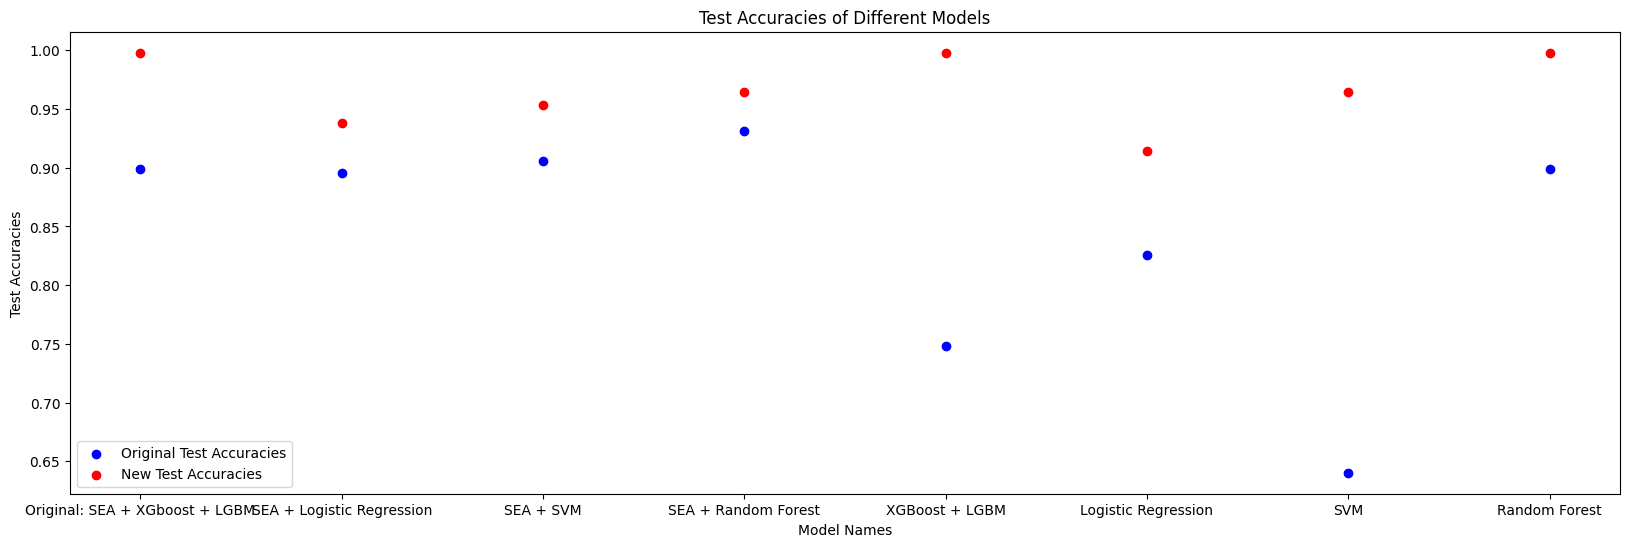

In [37]:
# Set the figure size
plt.figure(figsize=(20, 6))

# Create the original scatter plot
plt.scatter(model_names, test_accs, color='blue', label='Original Test Accuracies')

# Add the new data to the plot
plt.scatter(model_names, test_accs_new, color='red', label='New Test Accuracies')

# Add labels and title
plt.xlabel('Model Names')
plt.ylabel('Test Accuracies')
plt.title('Test Accuracies of Different Models')

# Add a legend to differentiate between the original and new data
plt.legend()

# Show the plot
plt.show()